In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pycountry
import numpy as np

Cel: Identyfikacja wzroców migracyjnych
* Wykrycie głównych kierunków migracji w UE na podstawie dostępnych danych (kraj pochodzenia → kraj docelowy, trendy czasowe)
* Analiza migracji wewnątrzunijnej oraz spoza UE
* Analiza napływu uchodźców wojennych z Ukrainy
* Wykorzystane zestawy danych z Eurostatu:
    - Immigration by citizenship
    - All valid permits by citzenship on 31 December of each year
    - Beneficiaries of temporary protection at the end of the month by citizenship, age and sex - monthly data
    - Asylum applicants
    - Immigration by citizenship - combined data
    - Population by citizenship - combined data
* Refugees (Refugee Data Finder)

# Immigration by citizenship

Imigracja w tym zbiorze danych jest postrzegana jako zamieszaknie na terytorium państwa na okres wynoszący CO NAJMNIEJ 12 miesięcy. Dane wyłączają uchodźców z Ukrainy, korzystających z ochrony tymczasowej.

In [2]:
df = pd.read_csv('../processed_data/immigration_by_citizenship.csv')

eu_countries = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark",
    "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy",
    "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland", "Portugal",
    "Romania", "Slovakia", "Slovenia", "Spain", "Sweden", "United Kingdom"
]  # plus United Kingdom

eu_only = df[df["geo"].isin(eu_countries)]
eu_only = eu_only[eu_only['Country of citizenship'] != eu_only['geo']]


### Analiza ogólnej liczby imgrantów do krajów UE

In [3]:
eu_only = eu_only[
    ~eu_only["geo"].str.contains("European Union|Total", case=False, na=False) &
    ~eu_only["Country of citizenship"].str.contains("Reporting country|Asia|America|Africa|Europe|Oceanian", case=False, na=False)
]


continents_pattern = "Asia|America|Africa|Europe|Oceanian"
filtered = eu_only[~eu_only["Country of citizenship"].str.contains(continents_pattern, case=False, na=False)]

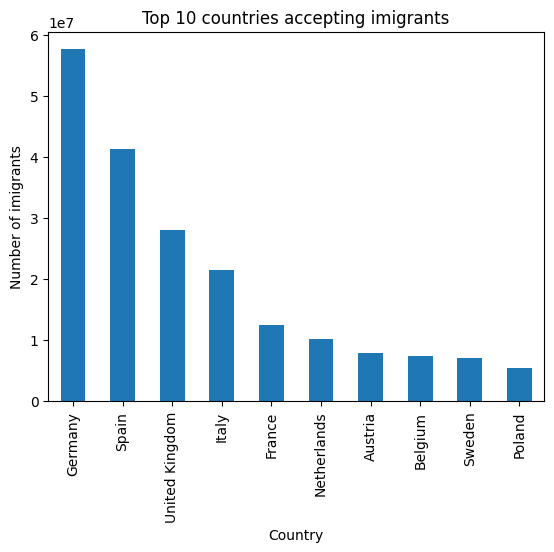

In [4]:
immigrants_by_country = filtered.groupby("geo")["Migrants number"].sum().sort_values(ascending=False)
immigrants_by_country.head(10).plot(kind='bar', title="Top 10 countries accepting imigrants")
plt.xlabel("Country")
plt.ylabel("Number of imigrants")
plt.show()


Najwięcej imigrantów przyjmują:
* NIEMCY
* HISZPANIA
* WIELKA BRYTANIA
* WŁOCHY
* HOLANDIA
* FRANCJA

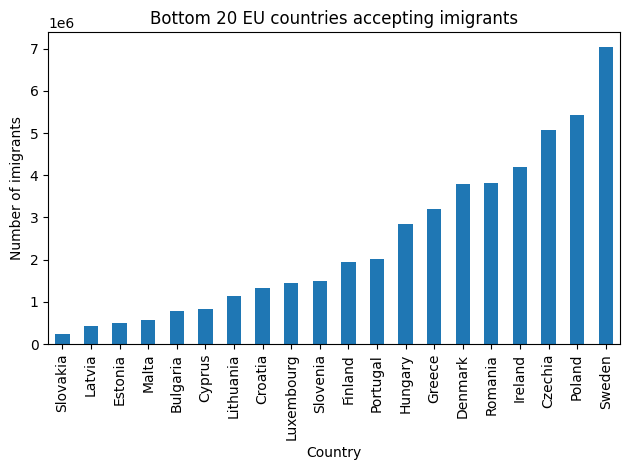

In [5]:
bottom15 = immigrants_by_country.sort_values().head(20)

bottom15.plot(kind='bar', title="Bottom 20 EU countries accepting imigrants")
plt.xlabel("Country")
plt.ylabel("Number of imigrants")
plt.tight_layout()
plt.show()

### Analiza według obywatelstwa (kraj pochodzenia)

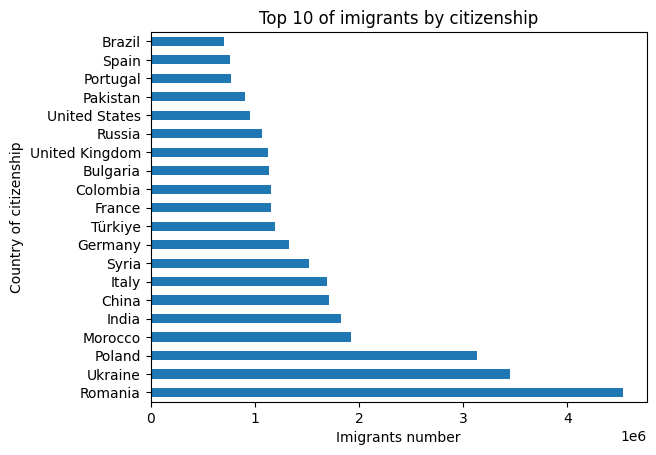

In [6]:
filtered_interest = filtered[~filtered["Country of citizenship"].str.contains("Reporting country|Foreign country|except|EU|Total|Stateless", case=False, na=False)]
top_origins = filtered_interest.groupby("Country of citizenship")["Migrants number"].sum().sort_values(ascending=False)

top_origins.head(20).plot(kind='barh', title="Top 10 of imigrants by citizenship")
plt.xlabel("Imigrants number")
plt.show()


### Macierze migracji: skąd -> dokąd

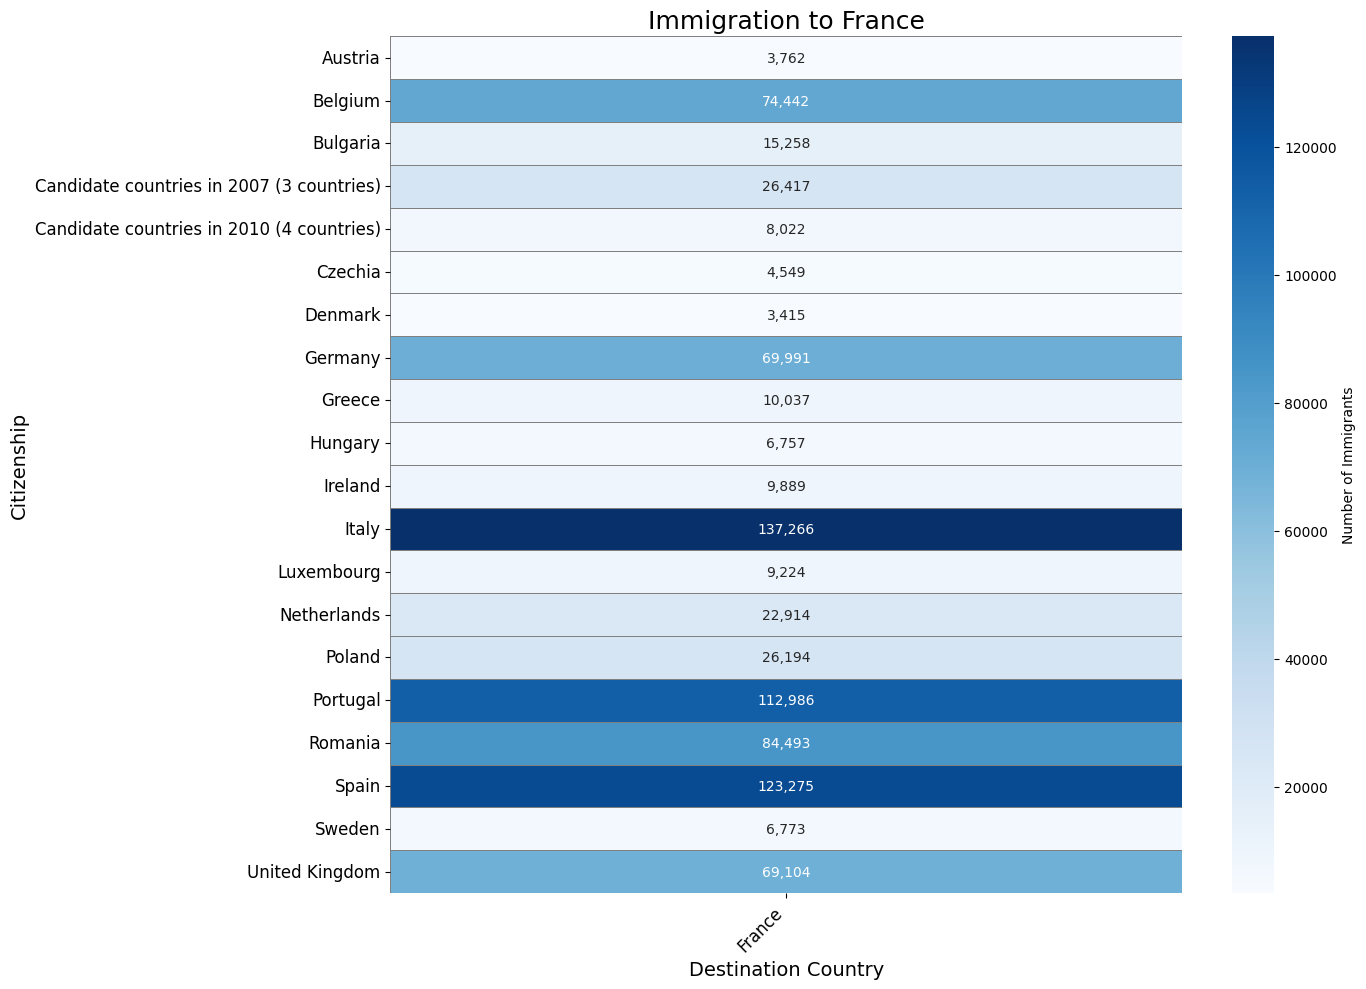

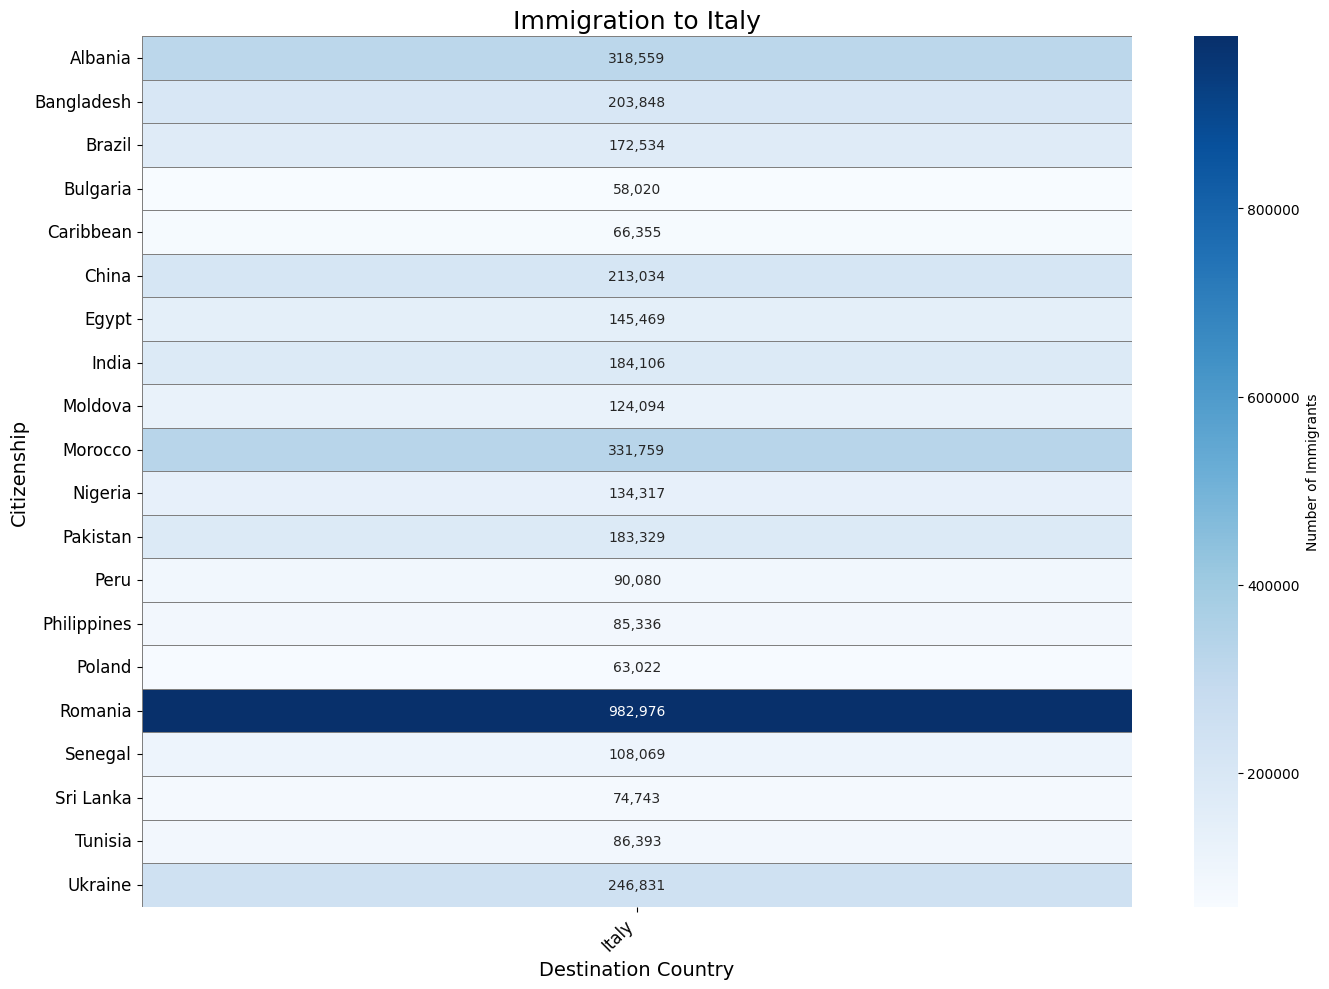

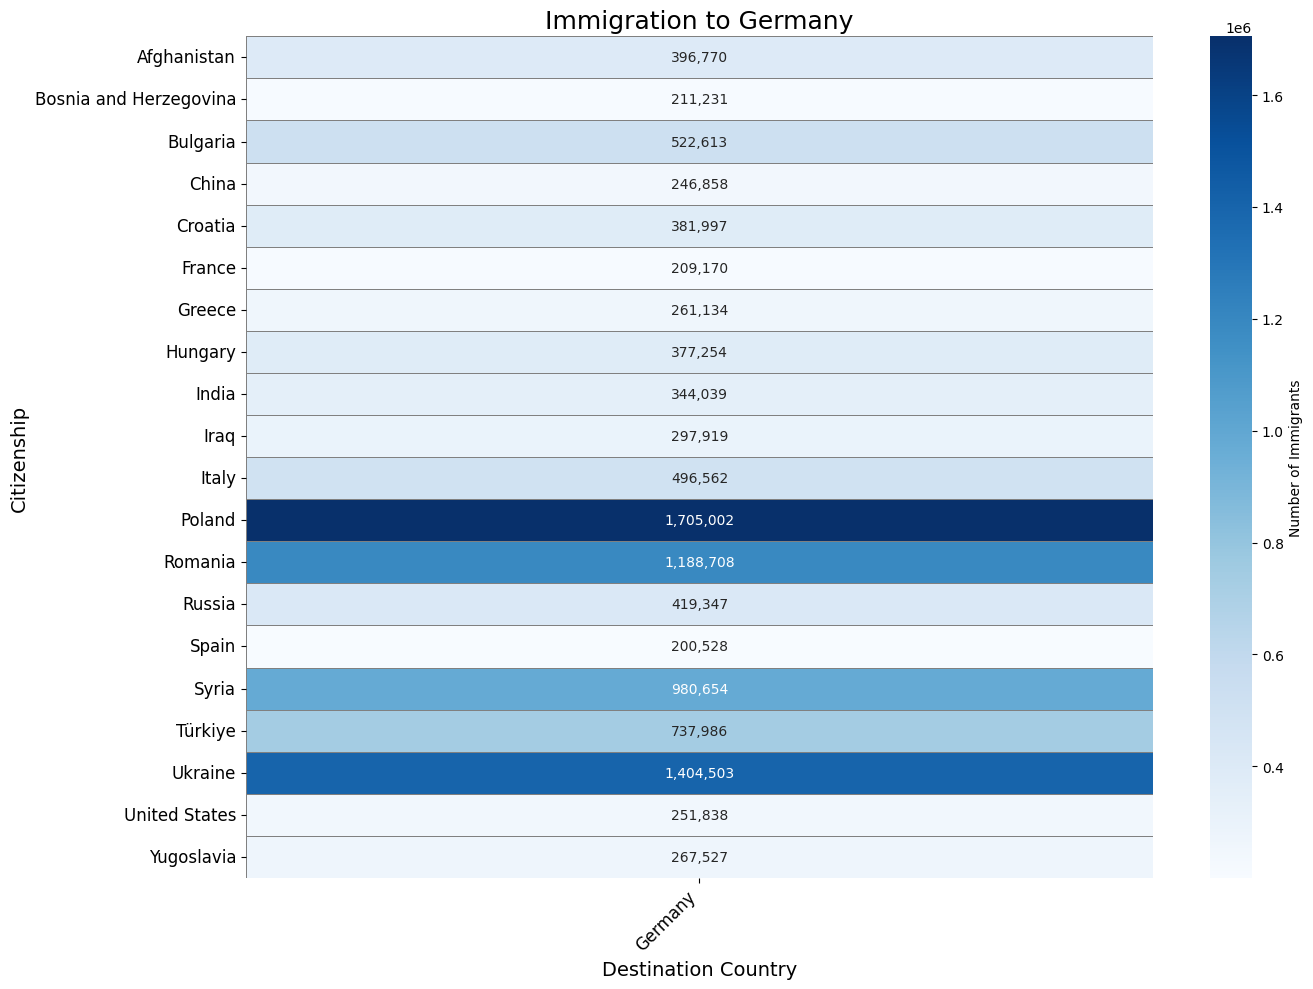

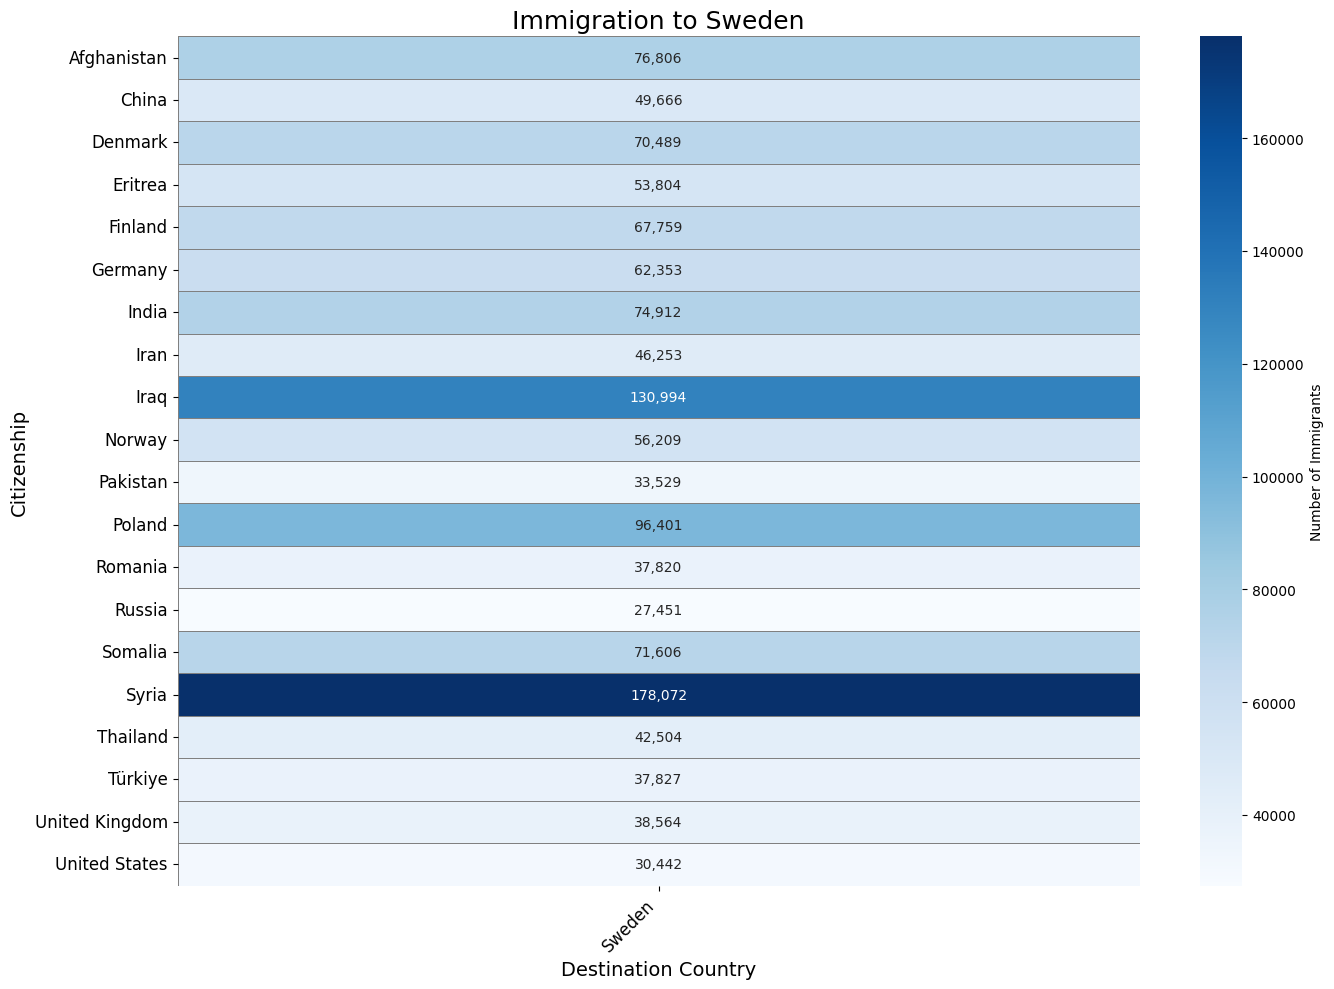

In [7]:

countries_of_interest = ['France', 'Italy', 'Germany', 'Sweden']


filtered_interest = filtered[~filtered["Country of citizenship"].str.contains(
    "Reporting country|Foreign country|except|EU|Total|Stateless", case=False, na=False)]
filtered_interest = filtered_interest[filtered_interest["geo"].isin(countries_of_interest)]


pivot_table = filtered_interest.pivot_table(
    index="Country of citizenship",
    columns="geo",
    values="Migrants number",
    aggfunc="sum"
)


pivot_table = pivot_table.apply(lambda x: x.nlargest(20), axis=0)


for country in countries_of_interest:

    country_data = pivot_table[[country]].fillna(0)
    country_data = country_data[country_data[country] > 0]

  
    plt.figure(figsize=(14, 10))  
    sns.heatmap(
        country_data, 
        cmap="Blues", 
        linewidths=0.7,  
        linecolor="gray", 
        cbar_kws={'label': 'Number of Immigrants'},
        annot=True,  
        fmt=",.0f" 
    )

    plt.title(f"Immigration to {country}", fontsize=18)  
    plt.xlabel("Destination Country", fontsize=14)  
    plt.ylabel("Citizenship", fontsize=14)  
    

    plt.xticks(rotation=45, ha="right", fontsize=12)  
    plt.yticks(fontsize=12)  
    plt.tight_layout() 

    
    plt.show()


Gdzie migrują Polacy?

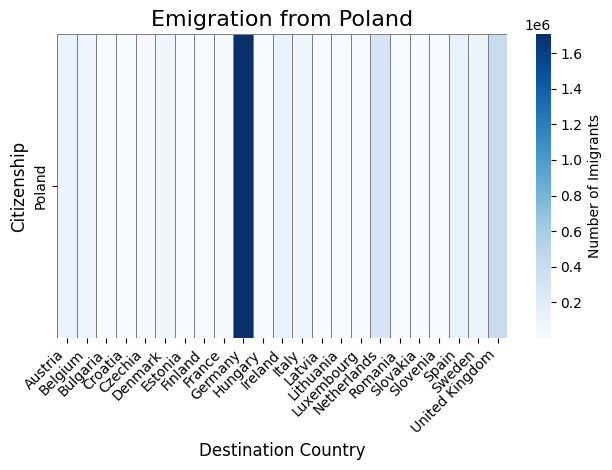

In [8]:
filtered_interest = filtered[filtered["Country of citizenship"] == "Poland"]

pivot_table = filtered_interest.pivot_table(
    index="Country of citizenship",
    columns="geo",
    values="Migrants number",
    aggfunc="sum"
)

sns.heatmap(
    pivot_table, 
    cmap="Blues", 
    linewidths=0.5, 
    linecolor="gray", 
    cbar_kws={'label': 'Number of Imigrants'}
)

plt.title(f"Emigration from Poland", fontsize=16)
plt.xlabel("Destination Country", fontsize=12)
plt.ylabel(f"Citizenship", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

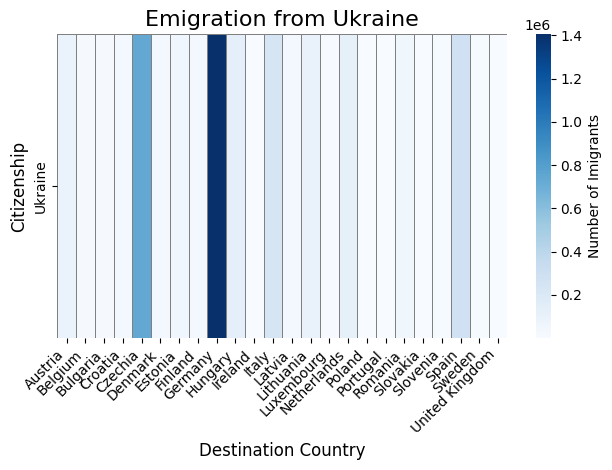

In [9]:
filtered_interest = filtered[filtered["Country of citizenship"] == "Ukraine"]

pivot_table = filtered_interest.pivot_table(
    index="Country of citizenship",
    columns="geo",
    values="Migrants number",
    aggfunc="sum"
)

sns.heatmap(
    pivot_table, 
    cmap="Blues", 
    linewidths=0.5, 
    linecolor="gray", 
    cbar_kws={'label': 'Number of Imigrants'}
)

plt.title(f"Emigration from Ukraine", fontsize=16)
plt.xlabel("Destination Country", fontsize=12)
plt.ylabel(f"Citizenship", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Trendy czasowe w migracji dla wybranych krajów

Dla całego świata

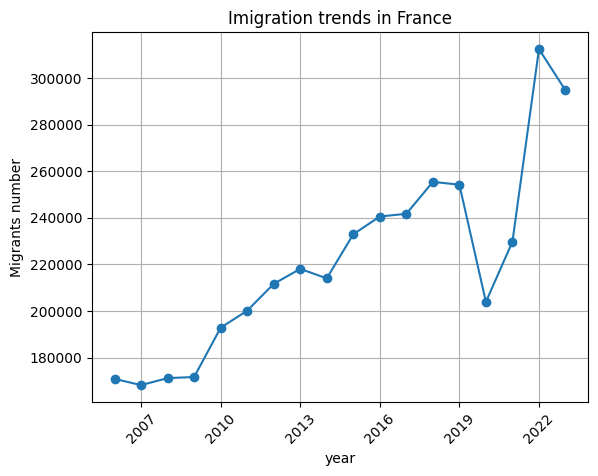

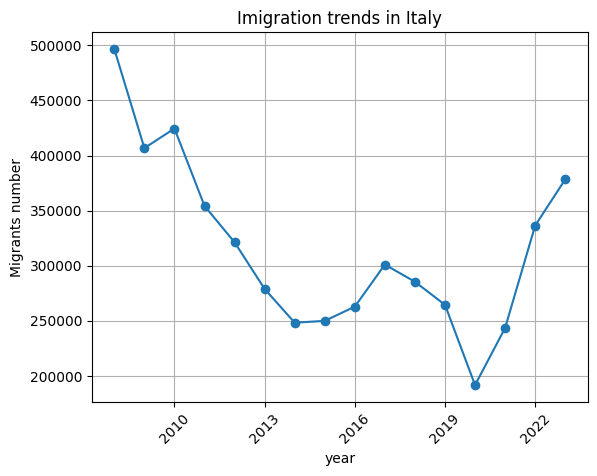

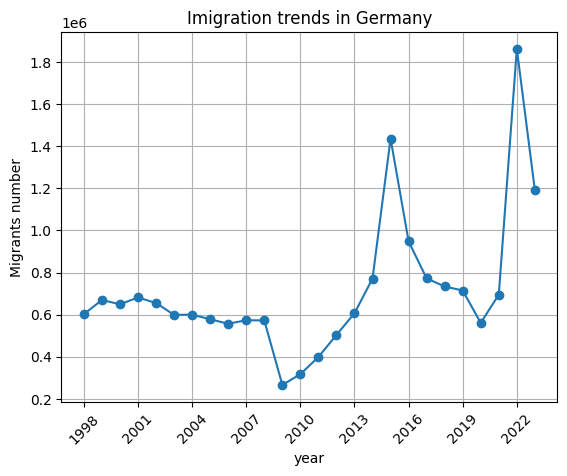

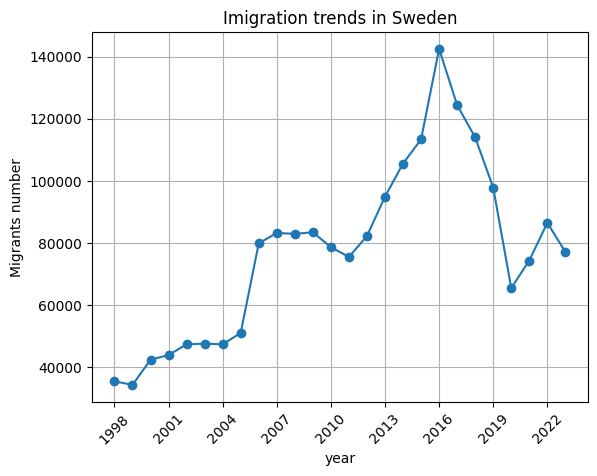

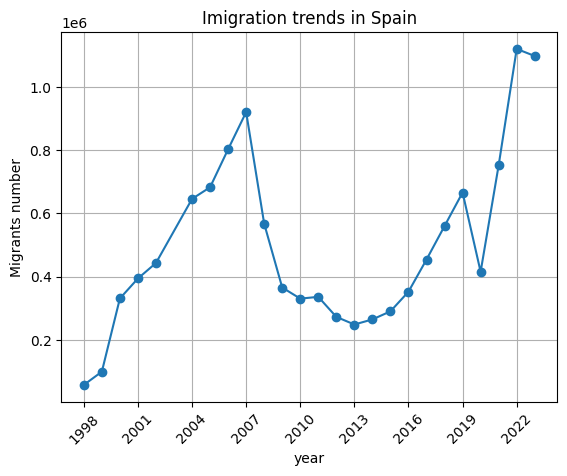

In [10]:
countries_of_interest = ['France', 'Italy', 'Germany', 'Sweden', 'Spain']

filtered_interest = filtered[(filtered["geo"].isin(countries_of_interest)) & (filtered["Country of citizenship"] == "Foreign country and stateless")]

for country in countries_of_interest:

    trend = filtered_interest[filtered_interest["geo"] == country].groupby("year")["Migrants number"].sum()

   
    trend.plot(title=f"Imigration trends in {country}", marker='o')
    plt.ylabel("Migrants number")
    
    
    years = sorted(trend.index.unique())
    ticks_every_3 = [year for year in years if year % 3 == 0]
    plt.xticks(ticks_every_3, rotation=45)
    
  
    plt.grid(True)
    

    plt.show()


C:\Users\natal\AppData\Local\Temp\ipykernel_7216\249683899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_interest["from_EU"] = filtered_interest["Country of citizenship"].isin(eu_countries)


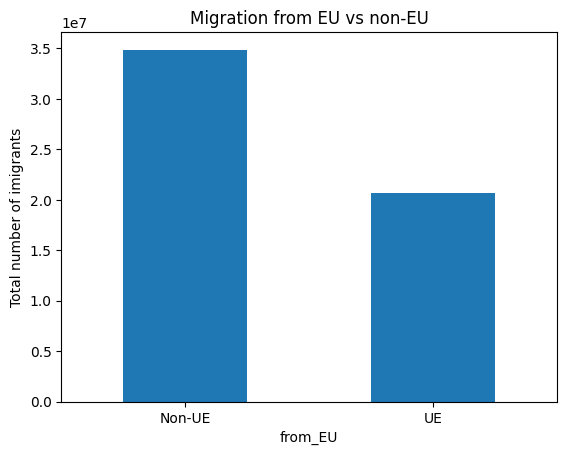

In [11]:
filtered_interest = filtered[~filtered["Country of citizenship"].str.contains("Reporting country|Foreign country|except|EU|Total|Stateless", case=False, na=False)]
filtered_interest["from_EU"] = filtered_interest["Country of citizenship"].isin(eu_countries)

filtered_interest.groupby("from_EU")["Migrants number"].sum().plot(kind='bar', title="Migration from EU vs non-EU")
plt.xticks([0, 1], ['Non-UE', 'UE'], rotation=0)
plt.ylabel("Total number of imigrants")
plt.show()

C:\Users\natal\AppData\Local\Temp\ipykernel_7216\1351838953.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_interest["from_EU"] = filtered_interest["Country of citizenship"].isin(eu_countries)


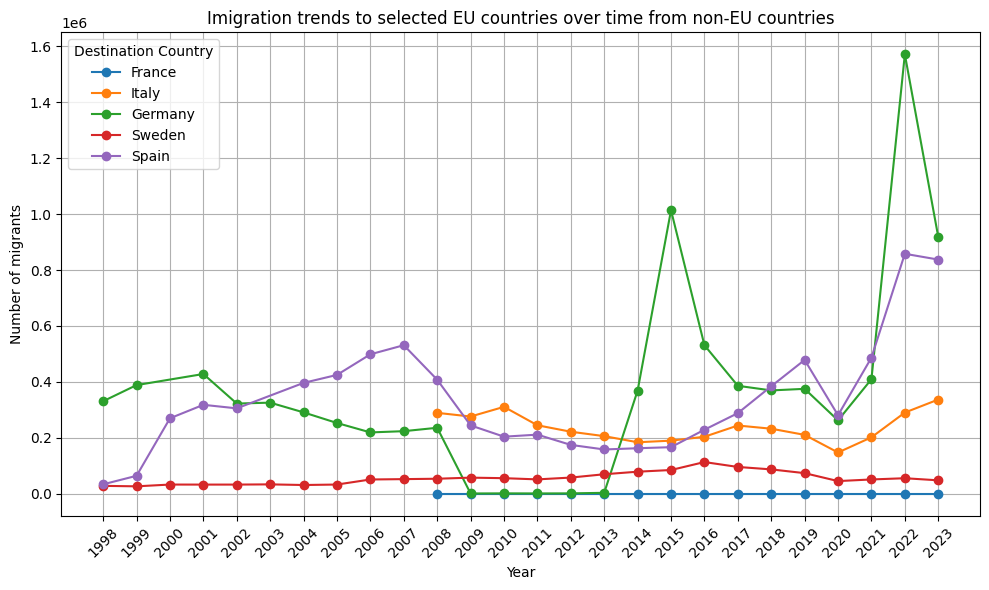

In [12]:
countries_of_interest = ['France', 'Italy', 'Germany', 'Sweden', 'Spain']

filtered_interest = filtered[
    ~filtered["Country of citizenship"].str.contains("Reporting country|Foreign country|except|EU|Total|candidate", case=False, na=False)
]

filtered_interest["from_EU"] = filtered_interest["Country of citizenship"].isin(eu_countries)

filtered_interest = filtered_interest[(filtered_interest["geo"].isin(countries_of_interest)) & ~(filtered_interest["from_EU"])]

plt.figure(figsize=(10, 6))

for country in countries_of_interest:
    trend = (
        filtered_interest[filtered_interest["geo"] == country]
        .groupby("year")["Migrants number"]
        .sum()
    )
    plt.plot(trend.index, trend.values, marker='o', label=country)


plt.title("Imigration trends to selected EU countries over time from non-EU countries")
plt.xlabel("Year")
plt.ylabel("Number of migrants")
plt.xticks(sorted(filtered_interest["year"].unique()), rotation=45)
plt.grid(True)
plt.legend(title="Destination Country")
plt.tight_layout()


plt.show()


C:\Users\natal\AppData\Local\Temp\ipykernel_7216\2993350355.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_interest["from_EU"] = filtered_interest["Country of citizenship"].isin(eu_countries)


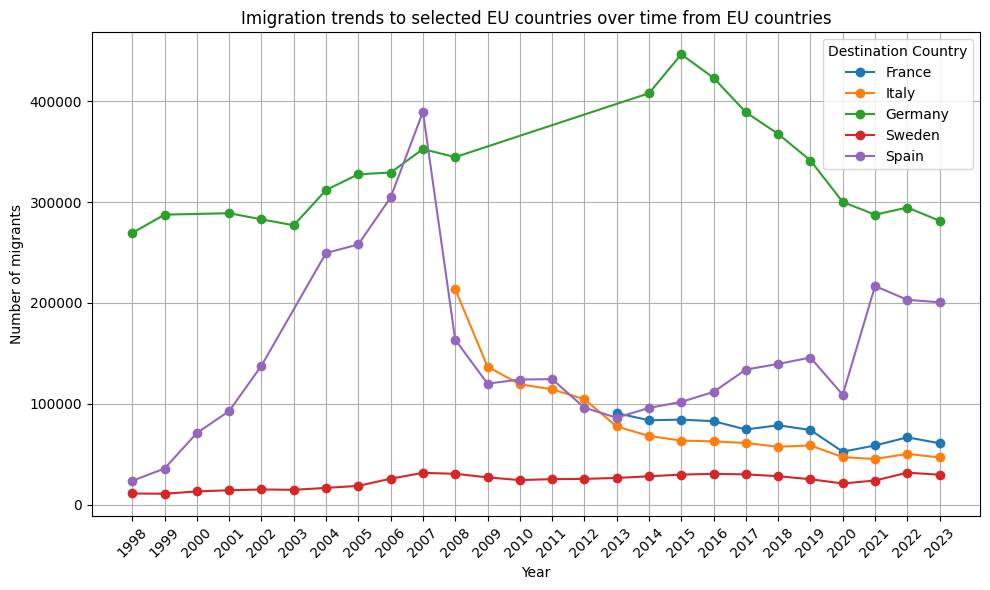

In [13]:
countries_of_interest = ['France', 'Italy', 'Germany', 'Sweden', 'Spain']


filtered_interest = filtered[~filtered["Country of citizenship"].str.contains("Reporting country|Foreign country|except|EU|Total|Stateless", case=False, na=False)]

filtered_interest["from_EU"] = filtered_interest["Country of citizenship"].isin(eu_countries)

filtered_interest = filtered_interest[(filtered_interest["geo"].isin(countries_of_interest)) & (filtered_interest["from_EU"])]

plt.figure(figsize=(10, 6))

for country in countries_of_interest:
    trend = (
        filtered_interest[filtered_interest["geo"] == country]
        .groupby("year")["Migrants number"]
        .sum()
    )
    plt.plot(trend.index, trend.values, marker='o', label=country)


plt.title("Imigration trends to selected EU countries over time from EU countries")
plt.xlabel("Year")
plt.ylabel("Number of migrants")
plt.xticks(sorted(filtered_interest["year"].unique()), rotation=45)
plt.grid(True)
plt.legend(title="Destination Country")
plt.tight_layout()


plt.show()



Analiza migracji w czasie dla Polski

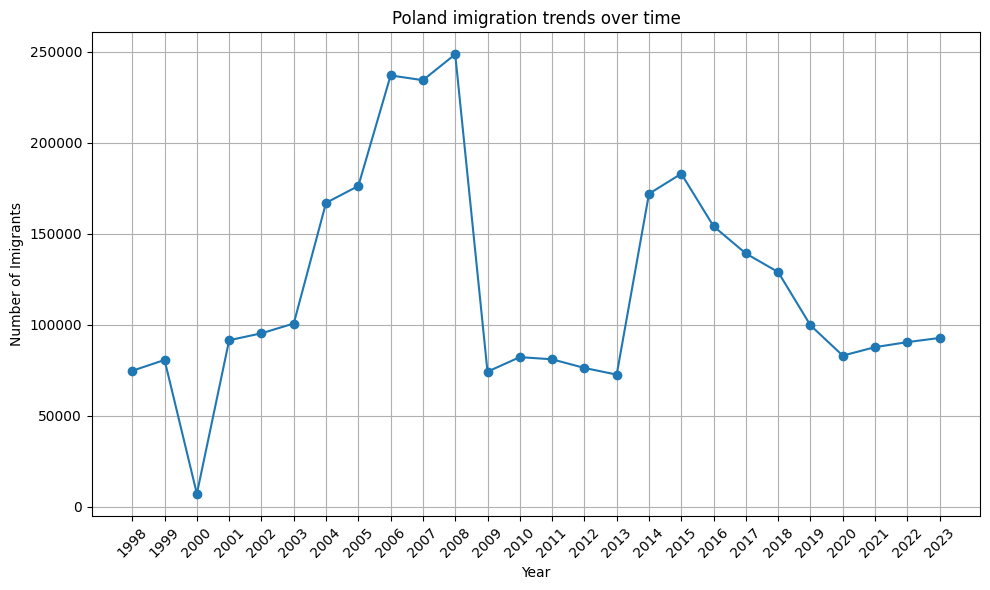

In [14]:
filtered_interest = filtered[filtered["Country of citizenship"] == "Poland"]

plt.figure(figsize=(10, 6))


trend = (
    filtered_interest
    .groupby("year")["Migrants number"]
    .sum()
)
plt.plot(trend.index, trend.values, marker='o', label=country)

plt.title("Poland imigration trends over time")
plt.xlabel("Year")
plt.ylabel("Number of Imigrants")
plt.xticks(sorted(filtered_interest["year"].unique()), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

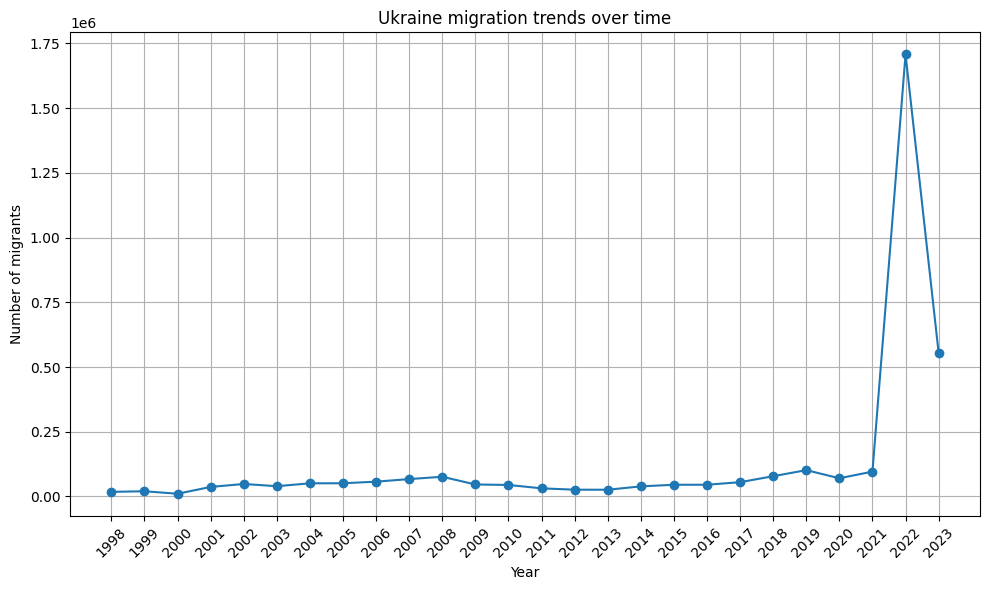

In [15]:
filtered_interest = filtered[filtered["Country of citizenship"] == "Ukraine"]

plt.figure(figsize=(10, 6))


trend = (
    filtered_interest
    .groupby("year")["Migrants number"]
    .sum()
)
plt.plot(trend.index, trend.values, marker='o', label=country)

plt.title("Ukraine migration trends over time")
plt.xlabel("Year")
plt.ylabel("Number of migrants")
plt.xticks(sorted(filtered_interest["year"].unique()), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Mapy

In [ ]:
eu_only = eu_only[
    ~eu_only["geo"].str.contains("European Union|Total", case=False, na=False) &
    ~eu_only["Country of citizenship"].str.contains("Reporting country|Asia|America|Africa|Europe|Oceanian", case=False, na=False)
]

def get_iso3(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None


continents_pattern = "Asia|America|Africa|Europe|Oceanian"
filtered = eu_only[~eu_only["Country of citizenship"].str.contains(continents_pattern, case=False, na=False)]
filtered['iso_a3'] = filtered['geo'].apply(get_iso3)

In [ ]:
filt = filtered.groupby(['geo', 'iso_a3'], as_index=False).agg({
    'Migrants number': 'sum'
})
filt.rename(columns={'Migrants number': 'Migrants number_sum'}, inplace=True)



fig = px.choropleth(
    filt,
    locations='iso_a3',
    color='Migrants number_sum',
    hover_name='geo',
    color_continuous_scale='thermal',
    title='Immigrants accepted in 1998–2023',
    scope='europe'
)
fig.show()

In [31]:
filt = filtered[(filtered['year'] >= 2015) & (filtered['year'] < 2024)]


filt = filt.groupby(['geo', 'iso_a3'], as_index=False).agg({
    'Migrants number': 'sum'
})
filt.rename(columns={'Migrants number': 'Migrants number_sum'}, inplace=True)



fig = px.choropleth(
    filt,
    locations='iso_a3',
    color='Migrants number_sum',
    hover_name='geo',
    color_continuous_scale='thermal',
    title='Migrants accepted in 2015–2023',
    scope='europe'
)
fig.show()

In [30]:
filt = filtered[(filtered['year'] == 2023)]


filt = filt.groupby(['geo', 'iso_a3'], as_index=False).agg({
    'Migrants number': 'sum'
})
filt.rename(columns={'Migrants number': 'Migrants number_sum'}, inplace=True)



fig = px.choropleth(
    filt,
    locations='iso_a3',
    color='Migrants number_sum',
    hover_name='geo',
    color_continuous_scale='thermal',
    title='Migrants accepted in 2023',
    scope='europe'
)
fig.show()

# All valid permits by reason, length of validity and citzenship on 31 December of each year

Zawiera szczegółowe informacje na temat ważnych pozwoleń na pobyt wydanych cudzoziemcom w krajach UE i EFTA na koniec każdego roku. Zbiór nie bierze pod uwagę uchodźców wojennych.

In [24]:
all_valid_permits = pd.read_csv('../processed_data/migrants_all_valid_permits.csv')

all_valid_permits = all_valid_permits[~all_valid_permits["geo"].str.contains("European", case=False, na=False)]


In [25]:
all_valid_permits.head()

Country of citizenship      geo  Migrants number  year  Population  \
0                Andorra  Austria              1.0  2016     8700471   
1                Andorra  Austria              2.0  2017     8772865   
2                Andorra  Austria              2.0  2018     8822267   
3                Andorra  Austria              2.0  2019     8858775   
4                Andorra  Austria              2.0  2020     8901064   

   Migrants number per 100k inhabitants  
0                                  0.01  
1                                  0.02  
2                                  0.02  
3                                  0.02  
4                                  0.02

### Analiza wydanych pozwoleń w poszczególnych krajach

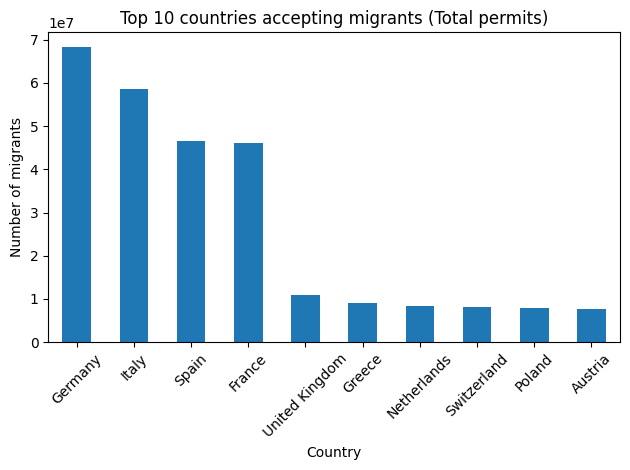

In [26]:
total_permits = all_valid_permits[all_valid_permits["Country of citizenship"] == "Total"]

top10 = total_permits.groupby("geo")["Migrants number"].sum().sort_values(ascending=False).head(10)

top10.plot(kind='bar', title="Top 10 countries accepting migrants (Total permits)")
plt.xlabel("Country")
plt.ylabel("Number of migrants")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


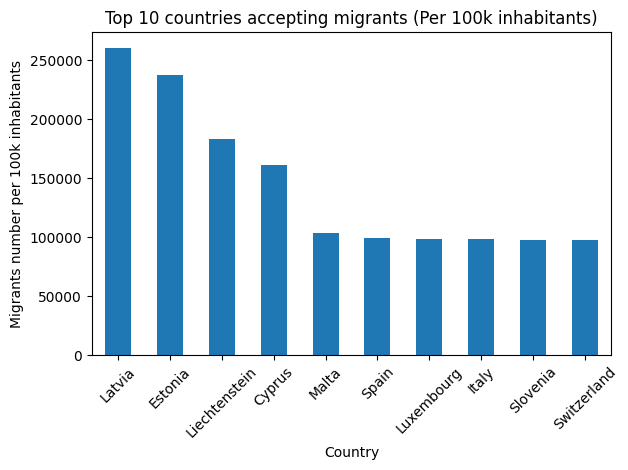

In [27]:
total_permits = all_valid_permits[all_valid_permits["Country of citizenship"] == "Total"]

top10 = total_permits.groupby("geo")["Migrants number per 100k inhabitants"].sum().sort_values(ascending=False).head(10)

top10.plot(kind='bar', title="Top 10 countries accepting migrants (Per 100k inhabitants)")
plt.xlabel("Country")
plt.ylabel("Migrants number per 100k inhabitants")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


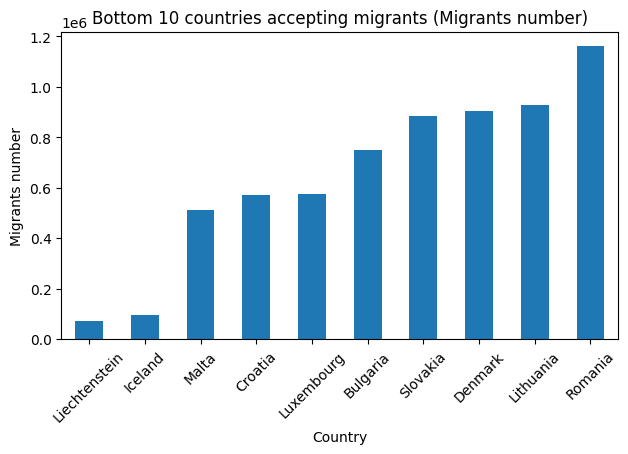

In [28]:
total_permits = all_valid_permits[all_valid_permits["Country of citizenship"] == "Total"]

bottom10 = total_permits.groupby("geo")["Migrants number"].sum().sort_values(ascending=True).head(10)

bottom10.plot(kind='bar', title="Bottom 10 countries accepting migrants (Migrants number)")
plt.xlabel("Country")
plt.ylabel("Migrants number")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


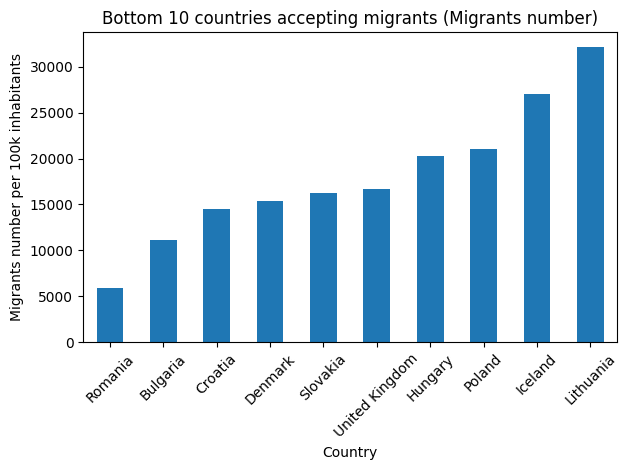

In [29]:
total_permits = all_valid_permits[all_valid_permits["Country of citizenship"] == "Total"]

bottom10 = total_permits.groupby("geo")["Migrants number per 100k inhabitants"].sum().sort_values(ascending=True).head(10)

bottom10.plot(kind='bar', title="Bottom 10 countries accepting migrants (Migrants number)")
plt.xlabel("Country")
plt.ylabel("Migrants number per 100k inhabitants")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Analiza wydanych pozwoleń (rozkład w czasie)

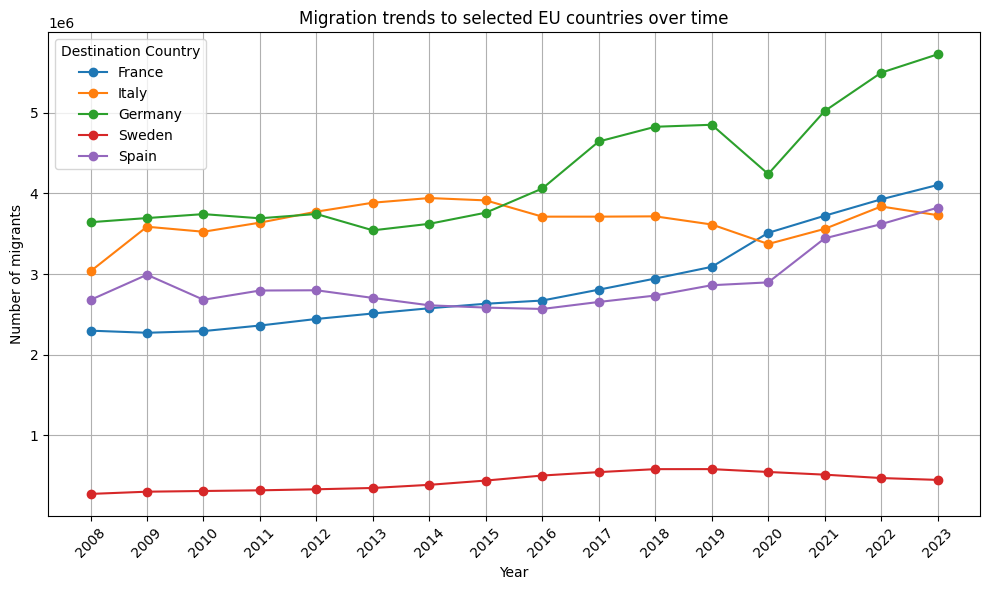

In [30]:
countries_of_interest = ['France', 'Italy', 'Germany', 'Sweden', 'Spain']

filtered_interest = all_valid_permits[
    (all_valid_permits["geo"].isin(countries_of_interest)) &
    (all_valid_permits["Country of citizenship"] == "Total")
]

plt.figure(figsize=(10, 6))

for country in countries_of_interest:
    trend = filtered_interest[filtered_interest["geo"] == country]
    plt.plot(trend["year"], trend["Migrants number"], marker='o', label=country)

plt.title("Migration trends to selected EU countries over time")
plt.xlabel("Year")
plt.ylabel("Number of migrants")
plt.xticks(sorted(filtered_interest["year"].unique()), rotation=45)
plt.grid(True)
plt.legend(title="Destination Country")
plt.tight_layout()
plt.show()




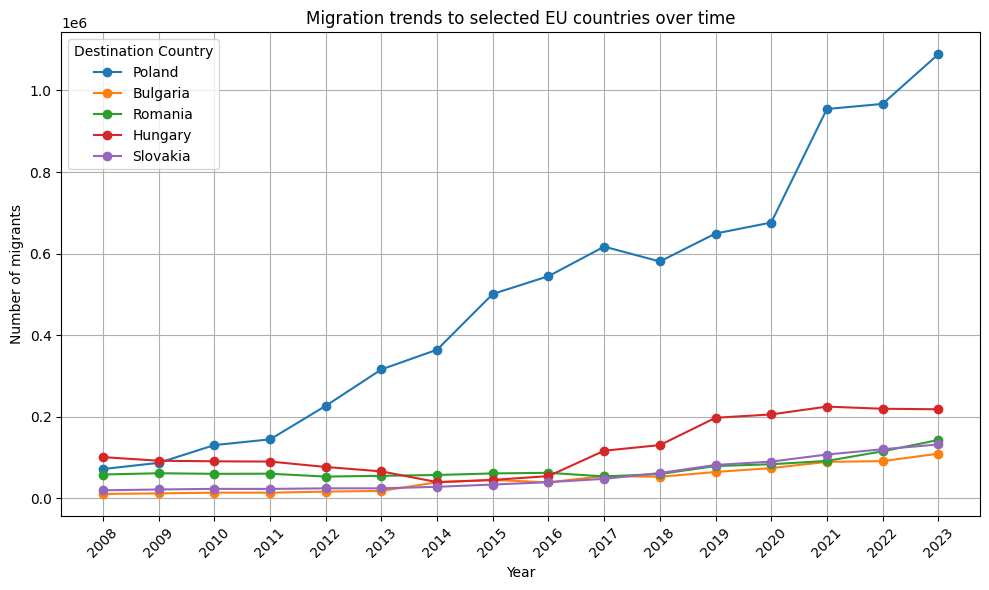

In [31]:
countries_of_interest = ['Poland', 'Bulgaria', 'Romania', 'Hungary', 'Slovakia']

filtered_interest = all_valid_permits[
    (all_valid_permits["geo"].isin(countries_of_interest)) &
    (all_valid_permits["Country of citizenship"] == "Total")
]

plt.figure(figsize=(10, 6))

for country in countries_of_interest:
    trend = filtered_interest[filtered_interest["geo"] == country]
    plt.plot(trend["year"], trend["Migrants number"], marker='o', label=country)

plt.title("Migration trends to selected EU countries over time")
plt.xlabel("Year")
plt.ylabel("Number of migrants")
plt.xticks(sorted(filtered_interest["year"].unique()), rotation=45)
plt.grid(True)
plt.legend(title="Destination Country")
plt.tight_layout()
plt.show()


In [32]:
eu_countries = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia',
    'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania',
    'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
    'Spain', 'Sweden', 'United Kingdom'
]  # plus United Kingdom!!

In [33]:
countries_of_interest = ['France', 'Italy', 'Germany', 'Sweden', 'Spain']
filtered_interest = all_valid_permits[all_valid_permits["geo"].isin(countries_of_interest)]
non_eu_filtered = filtered_interest[~filtered_interest["Country of citizenship"].isin(eu_countries)]

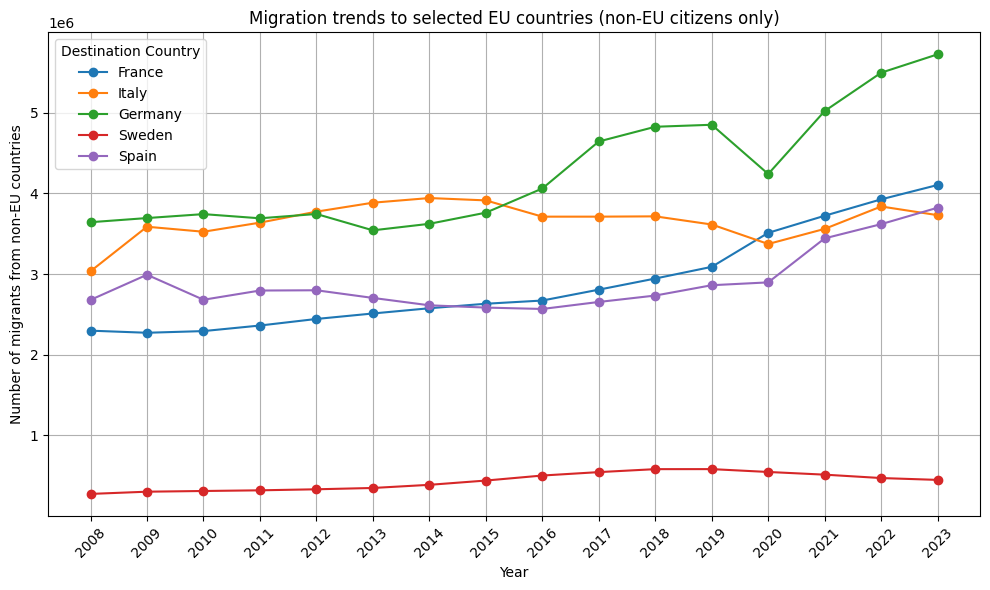

In [34]:
plt.figure(figsize=(10, 6))

for country in countries_of_interest:
    trend = non_eu_filtered[
        (non_eu_filtered["geo"] == country) & 
        (non_eu_filtered["Country of citizenship"] == "Total")
    ]
    trend = trend.sort_values("year")
    plt.plot(trend["year"], trend["Migrants number"], marker='o', label=country)

plt.title("Migration trends to selected EU countries (non-EU citizens only)")
plt.xlabel("Year")
plt.ylabel("Number of migrants from non-EU countries")
plt.xticks(sorted(non_eu_filtered["year"].unique()), rotation=45)
plt.grid(True)
plt.legend(title="Destination Country")
plt.tight_layout()
plt.show()

### Sprawdzenie trendów dla Ukrainy

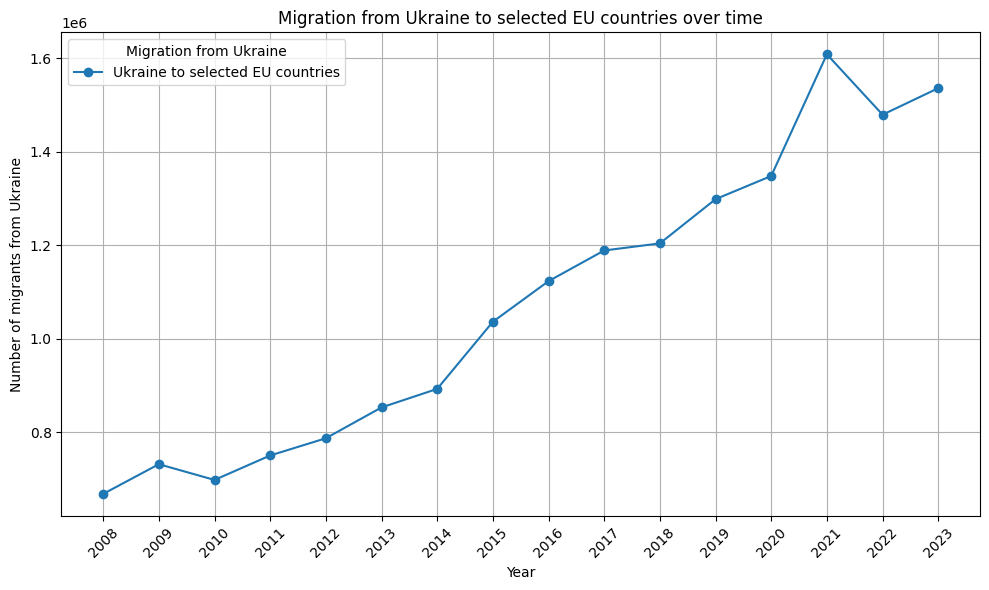

In [35]:
ukraine_migration = all_valid_permits[
    (all_valid_permits["Country of citizenship"] == "Ukraine")
]

ukraine_trends = ukraine_migration.groupby("year")["Migrants number"].sum()

plt.figure(figsize=(10, 6))
plt.plot(ukraine_trends.index, ukraine_trends.values, marker='o', label="Ukraine to selected EU countries")

plt.title("Migration from Ukraine to selected EU countries over time")
plt.xlabel("Year")
plt.ylabel("Number of migrants from Ukraine")
plt.xticks(sorted(ukraine_trends.index), rotation=45)
plt.grid(True)
plt.legend(title="Migration from Ukraine")
plt.tight_layout()
plt.show()


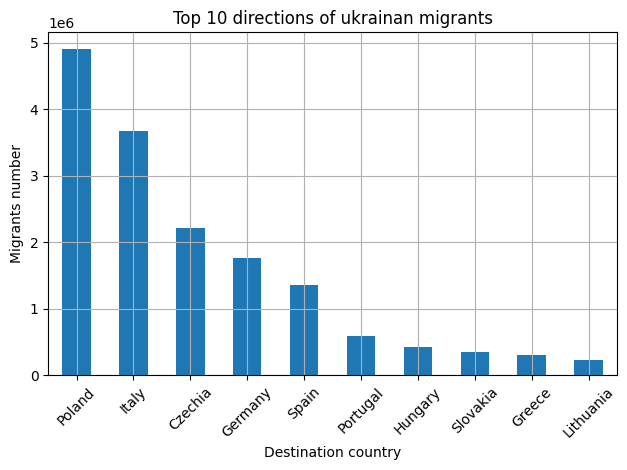

In [36]:
top_ukrain_dest = (
    ukraine_migration.groupby("geo")["Migrants number"]
    .sum()
    .sort_values(ascending=False)
)

top_ukrain_dest.head(10).plot(kind='bar', title="Top 10 directions of ukrainan migrants")
plt.xlabel("Destination country")
plt.ylabel("Migrants number")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Analiza kierunków,z których pochodzą migranci któym wydano zgody na pobyt

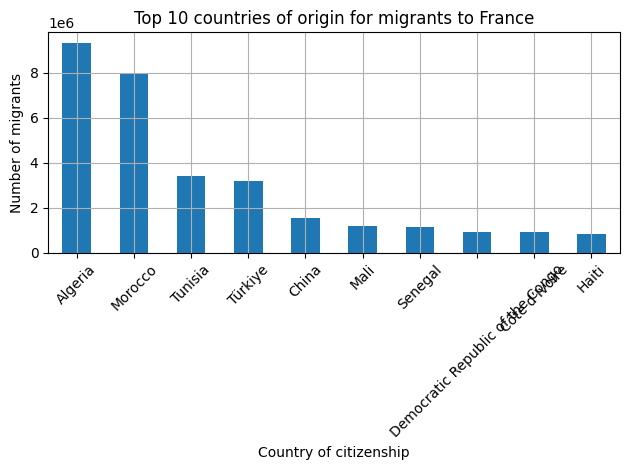

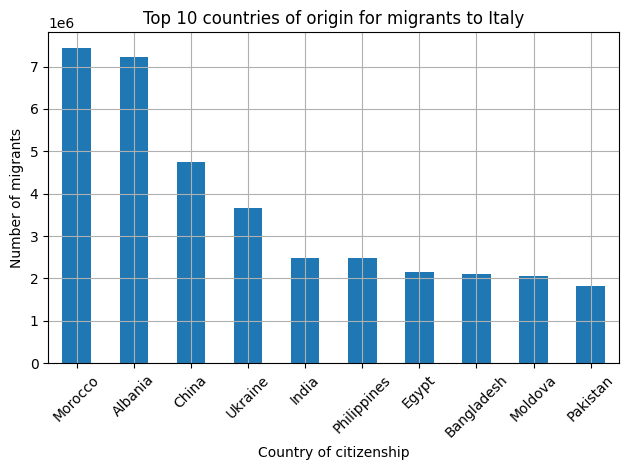

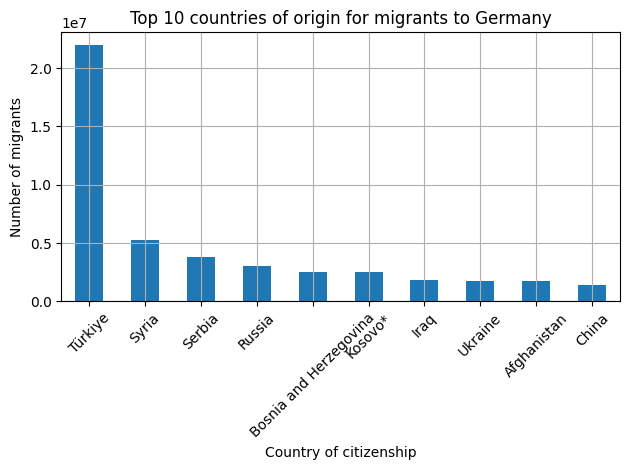

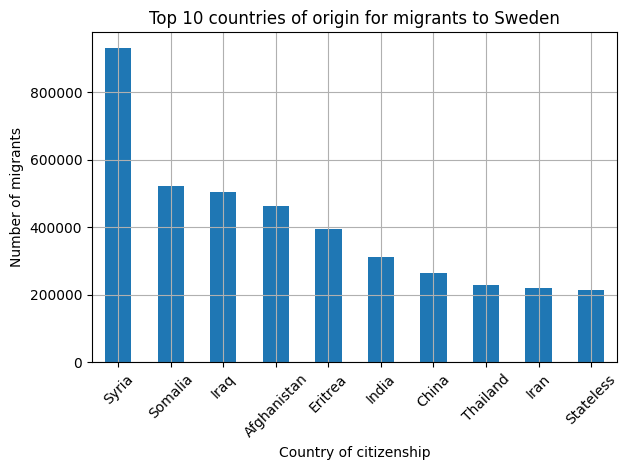

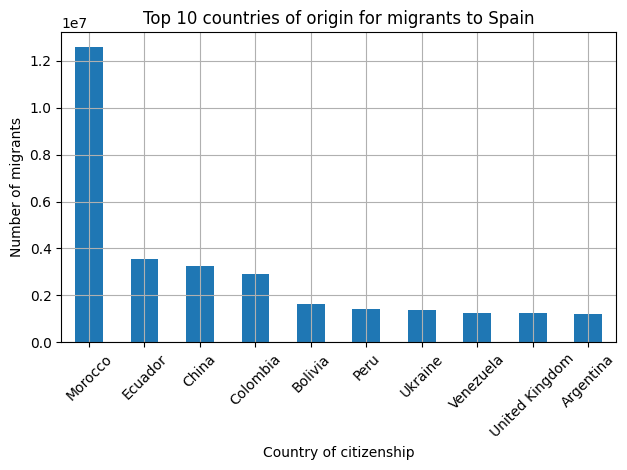

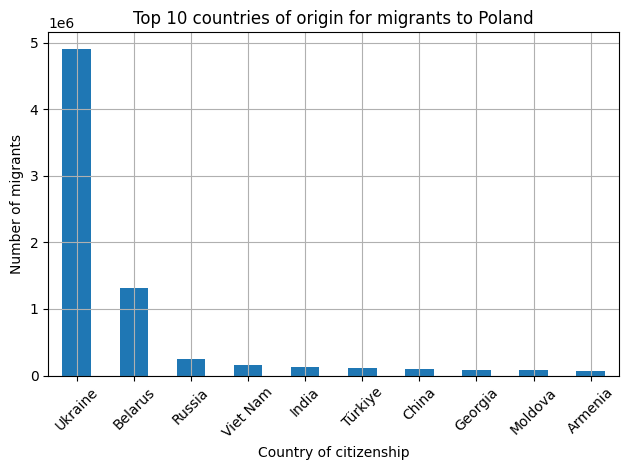

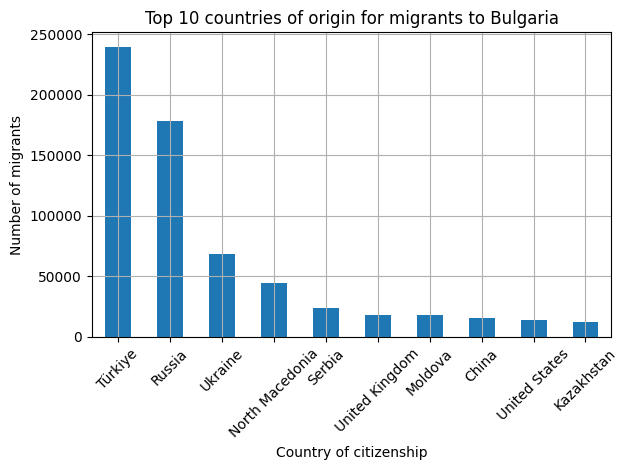

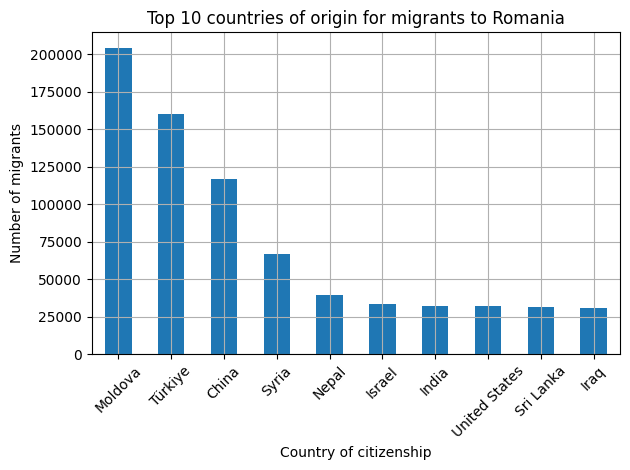

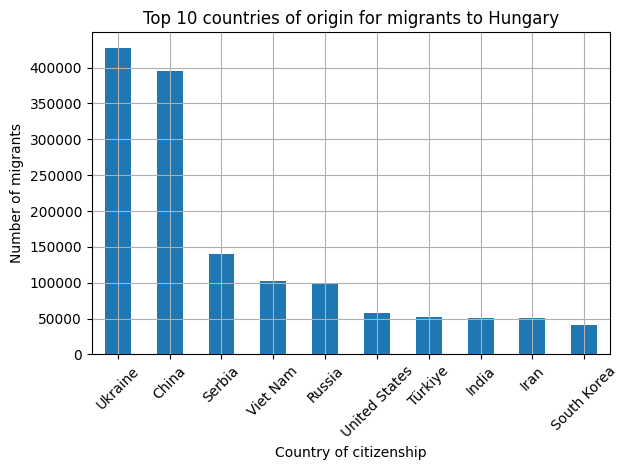

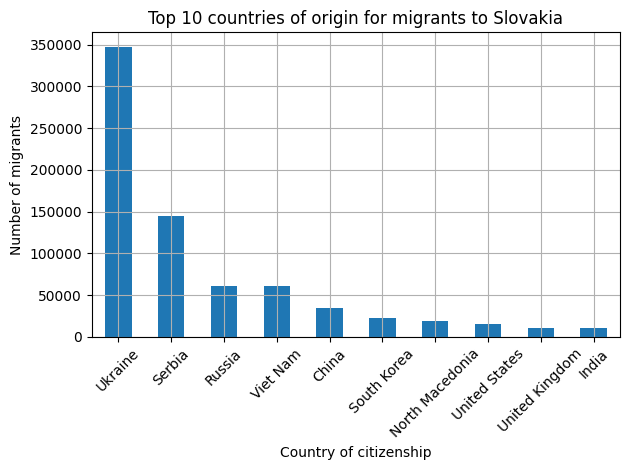

In [37]:
countries_of_interest = ['France', 'Italy', 'Germany', 'Sweden', 'Spain', 'Poland', 'Bulgaria', 'Romania', 'Hungary', 'Slovakia']


filtered = all_valid_permits[all_valid_permits["Country of citizenship"] != "Total"]

for country in countries_of_interest:

    country_data = filtered[filtered["geo"] == country]

    top_countries = (

        country_data.groupby("Country of citizenship")["Migrants number"]
        .sum()
        .sort_values(ascending=False)
        .head(10)  
    )


    top_countries.plot(kind='bar', title=f"Top 10 countries of origin for migrants to {country}")
    plt.xlabel("Country of citizenship")
    plt.ylabel("Number of migrants")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


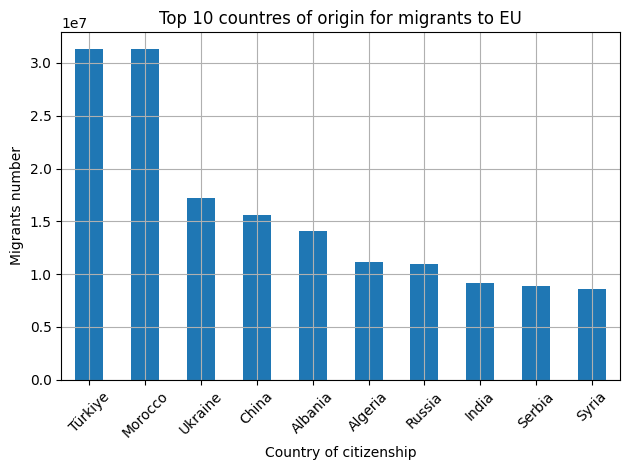

In [38]:
filtered = all_valid_permits[all_valid_permits["Country of citizenship"] != "Total"]

top_origin_countries = (
    filtered.groupby("Country of citizenship")["Migrants number"]
    .sum()
    .sort_values(ascending=False)
)

top_origin_countries.head(10).plot(kind='bar', title="Top 10 countres of origin for migrants to EU")
plt.xlabel("Country of citizenship")
plt.ylabel("Migrants number")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Beneficiaries of temporary protection at the end of the month - Ukraine analysis

In [39]:
ukraine_temp_prot = pd.read_csv('../processed_data/ukraine_temporary_protection.csv')
pd.to_datetime(ukraine_temp_prot['month'], format='%Y-%m')

0      2022-07-01
1      2022-08-01
2      2022-09-01
3      2022-10-01
4      2022-11-01
          ...    
1126   2024-11-01
1127   2024-12-01
1128   2025-01-01
1129   2025-02-01
1130   2025-03-01
Name: month, Length: 1131, dtype: datetime64[ns]

### Analiza kierunków

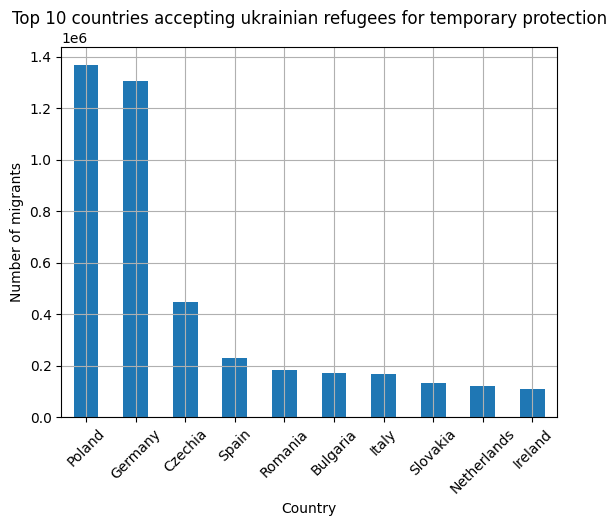

In [40]:
country_df = ukraine_temp_prot.groupby("geo")["OBS_VALUE"].max().sort_values(ascending=False)
country_df.head(10).plot(kind='bar', title="Top 10 countries accepting ukrainian refugees for temporary protection")
plt.xlabel("Country")
plt.ylabel("Number of migrants")
plt.xticks(rotation=45)
plt.grid(True)

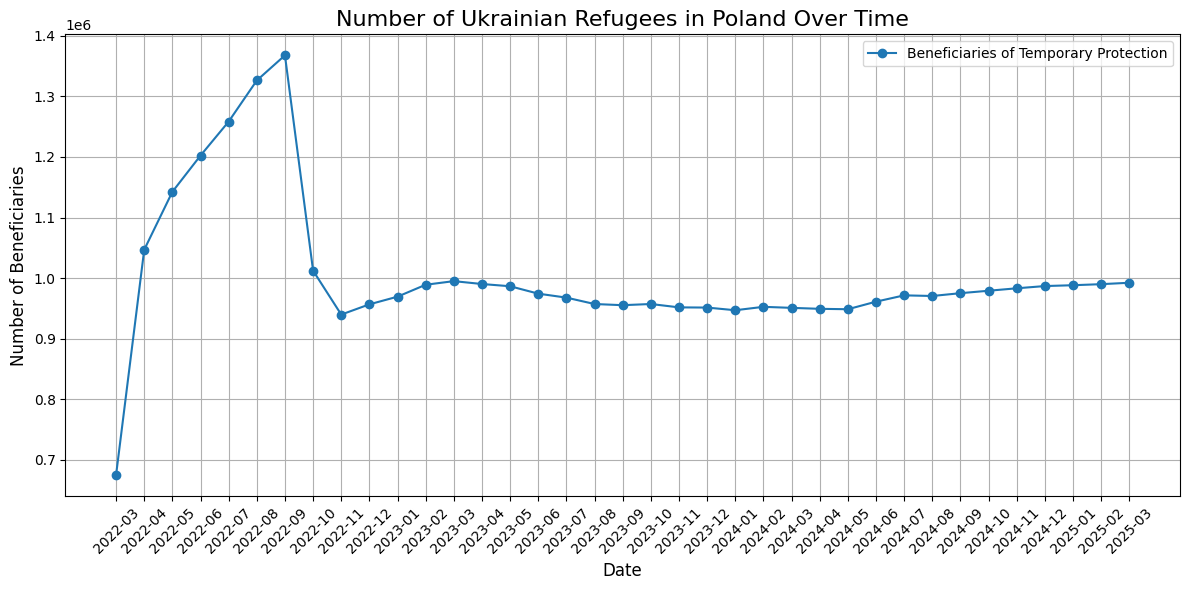

In [41]:
poland_data = ukraine_temp_prot[ukraine_temp_prot['geo'] == 'Poland']

poland_data = poland_data.sort_values('month')


plt.figure(figsize=(12, 6))

plt.plot(poland_data['month'], poland_data['OBS_VALUE'], marker='o', linestyle='-', label='Beneficiaries of Temporary Protection')

plt.title("Number of Ukrainian Refugees in Poland Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Beneficiaries", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



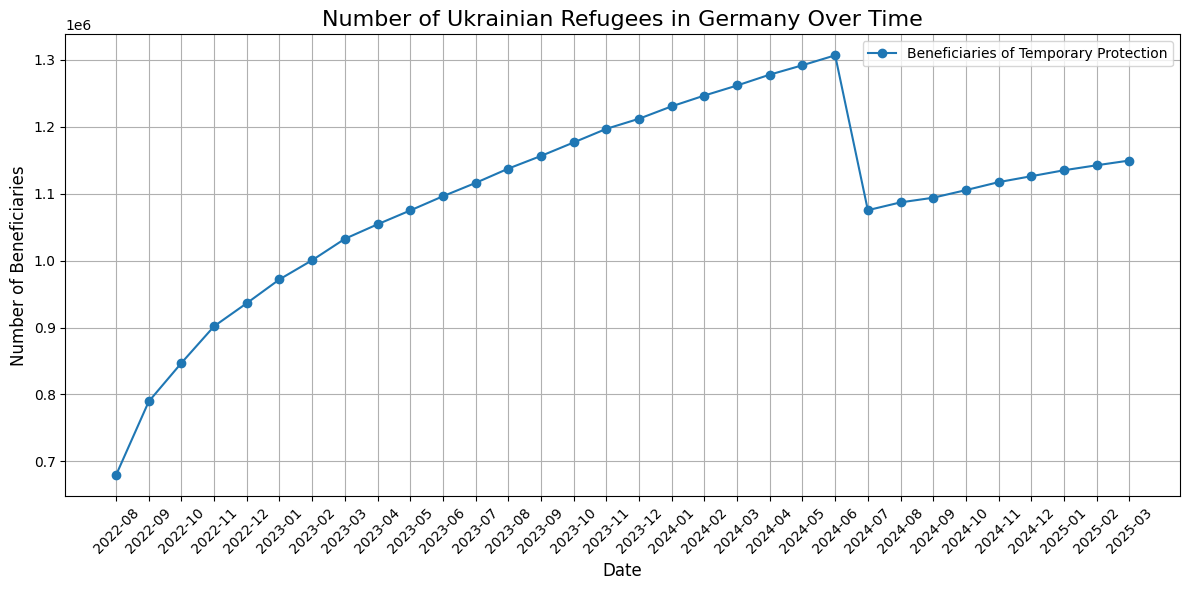

In [42]:
germany_data = ukraine_temp_prot[ukraine_temp_prot['geo'] == 'Germany']

germany_data = germany_data.sort_values('month')


plt.figure(figsize=(12, 6))

plt.plot(germany_data['month'], germany_data['OBS_VALUE'], marker='o', linestyle='-', label='Beneficiaries of Temporary Protection')

plt.title("Number of Ukrainian Refugees in Germany Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Beneficiaries", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# Asylum applciants

Analiza dla wszystich obywateli (Total) oraz w seperacji dla obywateli z Ukrainy

In [179]:
asyl = pd.read_csv('../processed_data/asylum_applicants.csv')

In [180]:
asyl.head()

Country of citizenship  year      geo  Number
0                  Total  2008  Austria   12750
1                  Total  2009  Austria   15815
2                  Total  2010  Austria   11060
3                  Total  2011  Austria   14455
4                  Total  2012  Austria   17450

In [181]:
totals = asyl[asyl['Country of citizenship'] == 'Total']

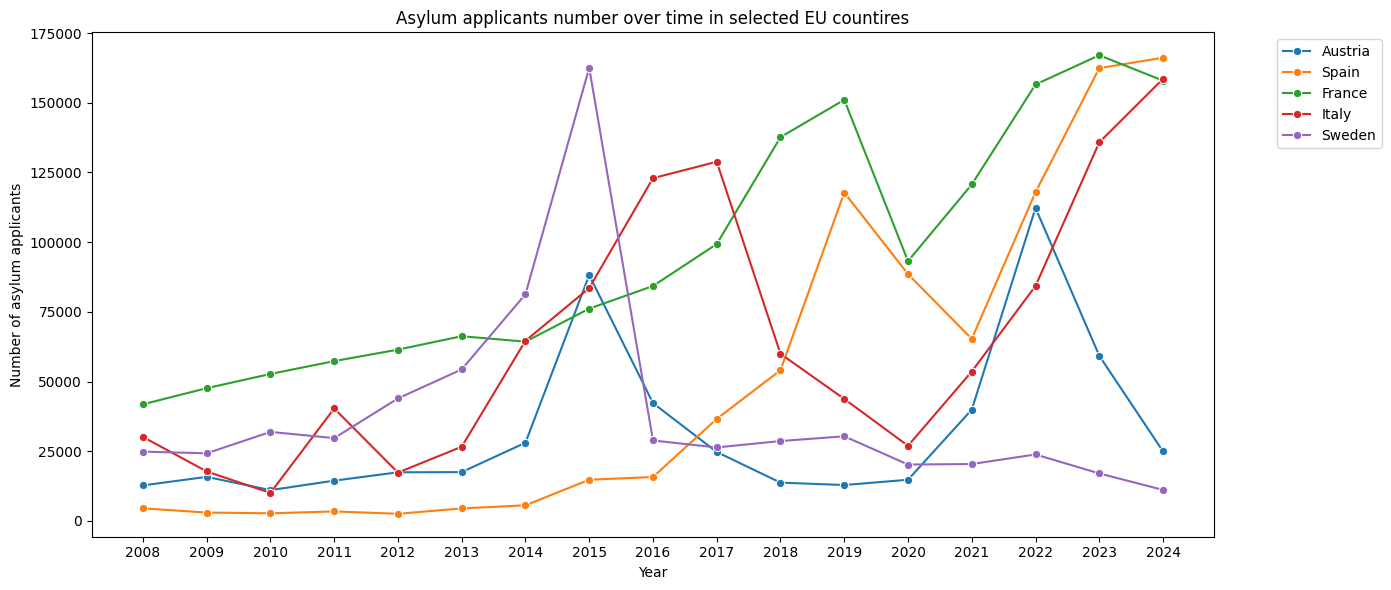

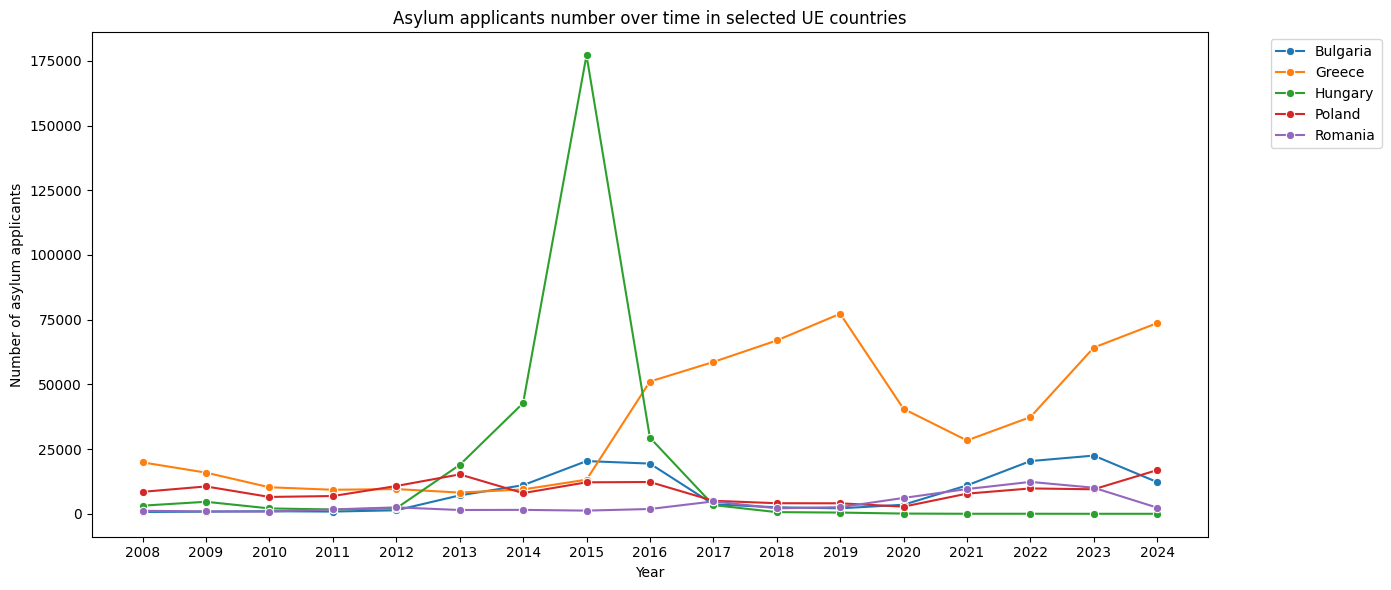

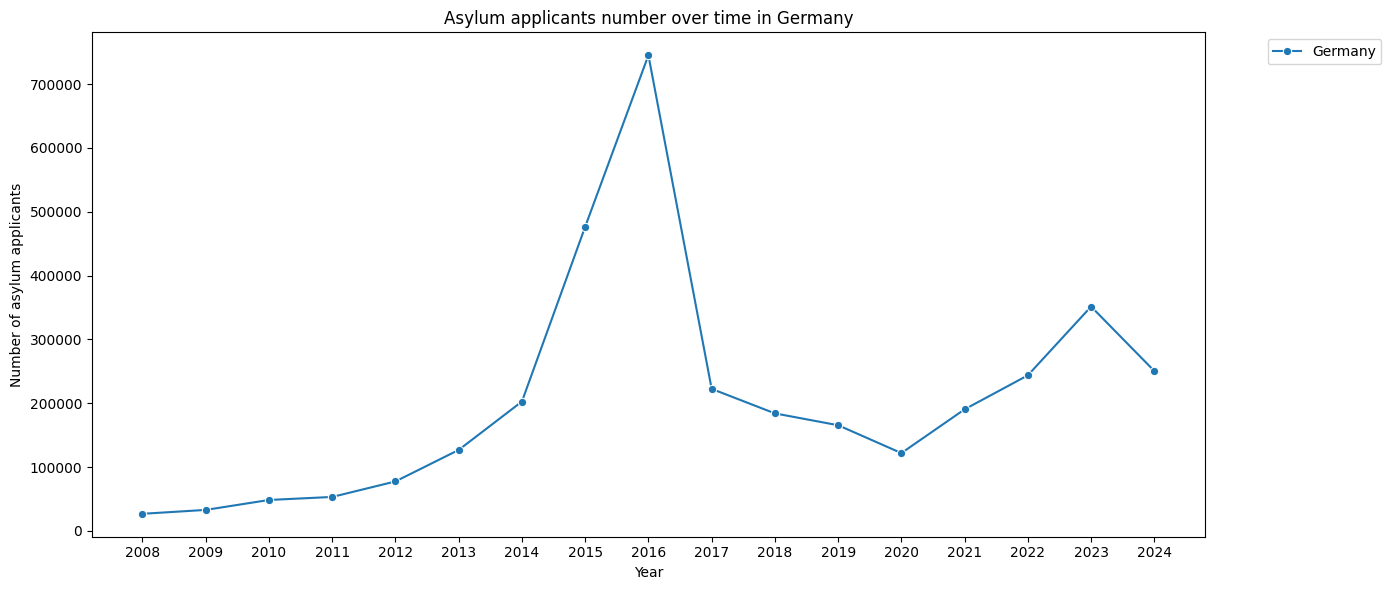

In [185]:
selected = ["Poland", "Bulgaria", "Romania", "Hungary", "France", "Italy", "Germany", "Sweden", "Spain", "Greece", "Austria"]
# liberal countries
liberal = ["France", "Italy", "Sweden", "Spain", "Austria"]

plt.figure(figsize=(14, 6))  # Niemcy zaburzają ładny wykres
sns.lineplot(data=totals[totals['geo'].isin(liberal)], x="year", y="Number", hue="geo", marker="o")
plt.title("Asylum applicants number over time in selected EU countires")
plt.ylabel("Number of asylum applicants")
plt.xlabel("Year")
plt.xticks(np.sort(totals[totals['geo'].isin(liberal)]['year'].unique()))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# conservative countries
conservs = ["Poland", "Bulgaria", "Romania", "Hungary", "Greece"]
plt.figure(figsize=(14, 6))
sns.lineplot(data=totals[totals['geo'].isin(conservs)], x="year", y="Number", hue="geo", marker="o")
plt.title("Asylum applicants number over time in selected UE countries")
plt.ylabel("Number of asylum applicants")
plt.xlabel("Year")
plt.xticks(np.sort(totals[totals['geo'].isin(liberal)]['year'].unique()))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))
sns.lineplot(data=totals[totals['geo'] == "Germany"], x="year", y="Number", hue="geo", marker="o")
plt.title("Asylum applicants number over time in Germany")
plt.ylabel("Number of asylum applicants")
plt.xlabel("Year")
plt.xticks(np.sort(totals[totals['geo'].isin(liberal)]['year'].unique()))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Dla krajów liberalnych wartości nie przekraczją 175 tysięcy, dla konserwatywnych (oprócz piku w 2015 roku dla Węgier) nie przkraczają 75 tysięcy. 

Ekstremalnym przypadkiem są Niemcy, dla których liczba wniosków o azyl w 2016 roku wyniosła 700tys. Prawdopodobnie wynika to z zaostrzenia się konfiktów w regionach Syria/Irak oraz napływu imigrantów szlakiem bałkańskim. Późniejszy spadek wynika z decyzji o zamknięciu tego szlaku oraz relokacji migrantów do inncyh krajów UE (w nich wzrost).

W 2022/2023 nie zaobserwowano wyraźnych zmian wzrostowych związanych z wybuchem wojny w Ukrainie. Ukraińcy korzystali/korzystają z tymczaswoych ochron/statusu uchodźcy wojennego.

# Immigration by citizenship combined data

In [140]:
combined = pd.read_csv('../processed_data/immigration_by_citizenship_combined_data.csv')

In [141]:
combined.head()

geo  year       EU  Ukraine  national    non_EU  foreigners  \
0  Austria  1998  27468.0    410.0   13494.0  101367.0    128835.0   
1  Austria  1999  30266.0    582.0   14331.0  128227.0    158493.0   
2  Austria  2001  36068.0    777.0   15142.0  134108.0    170176.0   
3  Austria  2002  34008.0   1103.0   21981.0  137932.0    171940.0   
4  Austria  2003  37727.0   1332.0   18528.0  148679.0    186406.0   

   foreigners_pop_share  non_EU_pop_share  ukraine_pop_share  \
0                   NaN               NaN                NaN   
1                   NaN               NaN                NaN   
2                   NaN               NaN                NaN   
3                   NaN               NaN                NaN   
4              2.301231          1.835481           0.016444   

   ukraine_for_share  non_EU_for_share iso_a3  
0           0.318237         78.679707    AUT  
1           0.367209         80.903888    AUT  
2           0.456586         78.805472    AUT  
3           0.641503         80.221007    AUT  
4           0.714569         79.760845    AUT

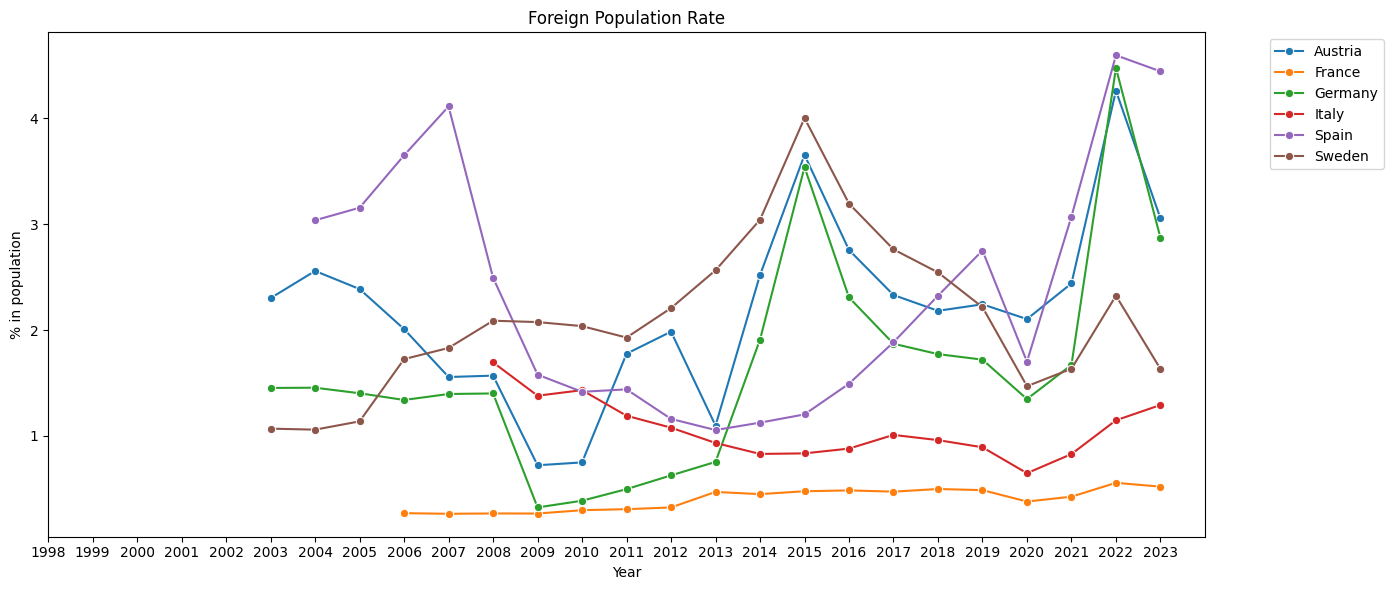

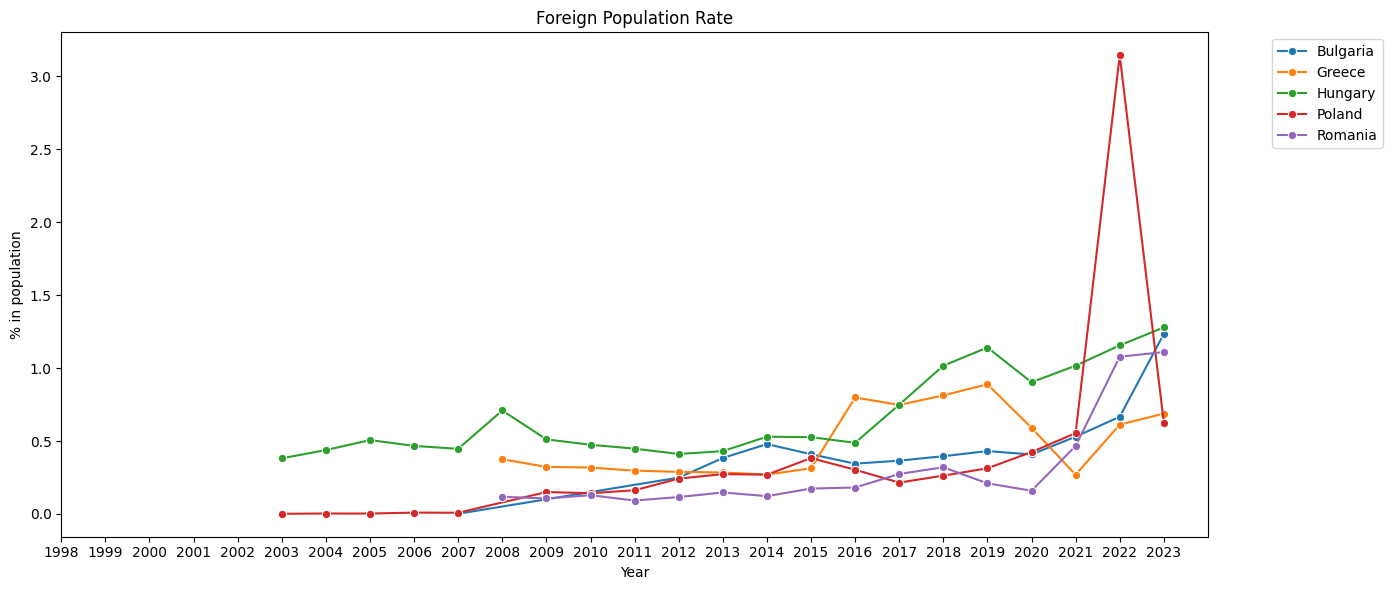

In [142]:
selected = ["Poland", "Bulgaria", "Romania", "Hungary", "France", "Italy", "Germany", "Sweden", "Spain", "Greece", "Austria"]
# liberal countries
liberal = ["France", "Italy", "Germany", "Sweden", "Spain", "Austria"]

plt.figure(figsize=(14, 6))
sns.lineplot(data=combined[combined['geo'].isin(liberal)], x="year", y="foreigners_pop_share", hue="geo", marker="o")
plt.title("Foreign Population Rate")
plt.ylabel("% in population")
plt.xlabel("Year")
plt.xticks(np.sort(combined[combined['geo'].isin(liberal)]['year'].unique()))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# conservative countries
conservs = ["Poland", "Bulgaria", "Romania", "Hungary", "Greece"]
plt.figure(figsize=(14, 6))
sns.lineplot(data=combined[combined['geo'].isin(conservs)], x="year", y="foreigners_pop_share", hue="geo", marker="o")
plt.title("Foreign Population Rate")
plt.ylabel("% in population")
plt.xlabel("Year")
plt.xticks(np.sort(combined[combined['geo'].isin(liberal)]['year'].unique()))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

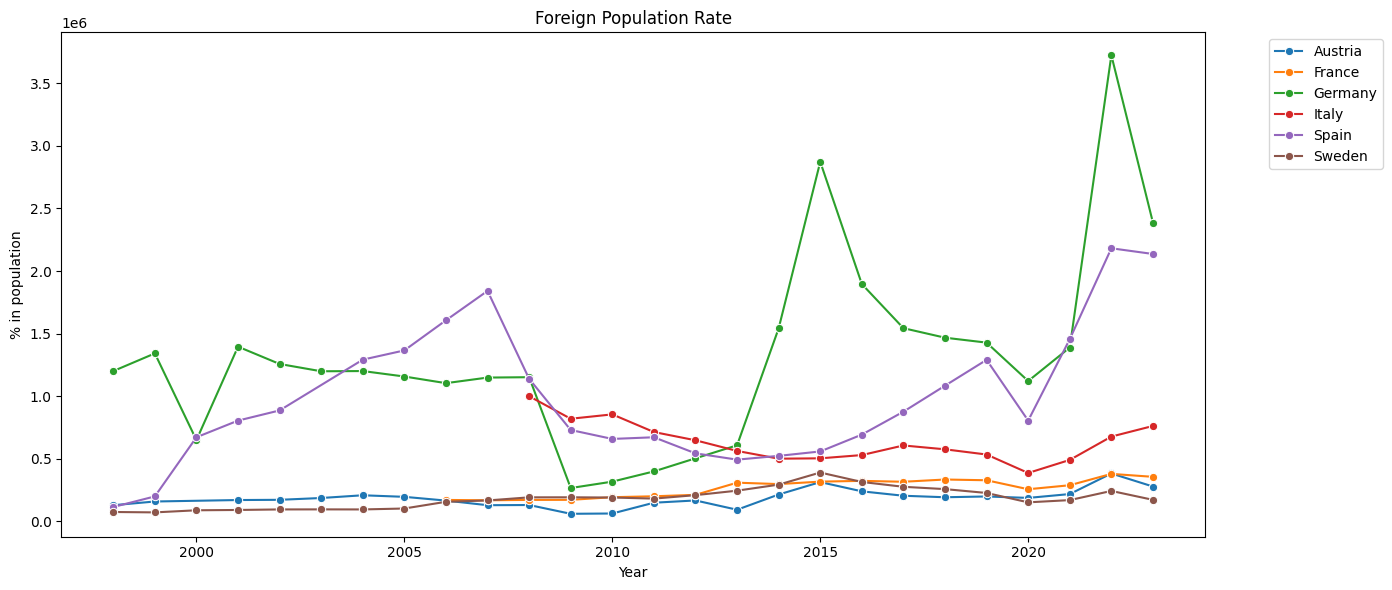

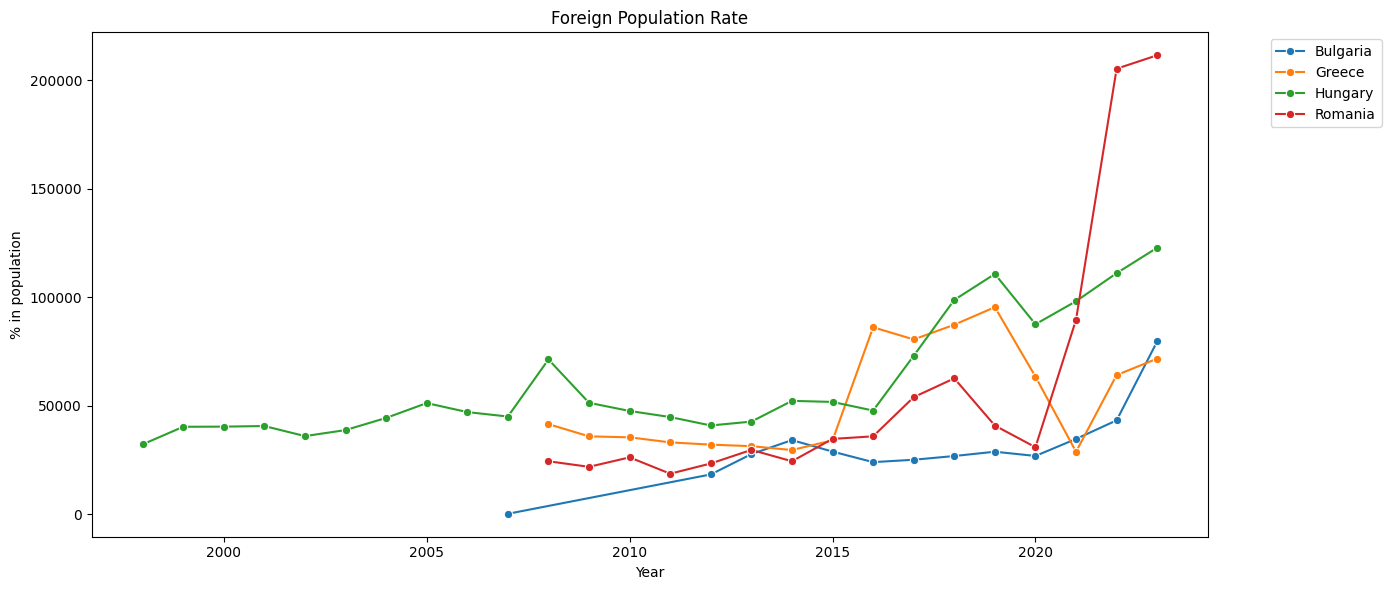

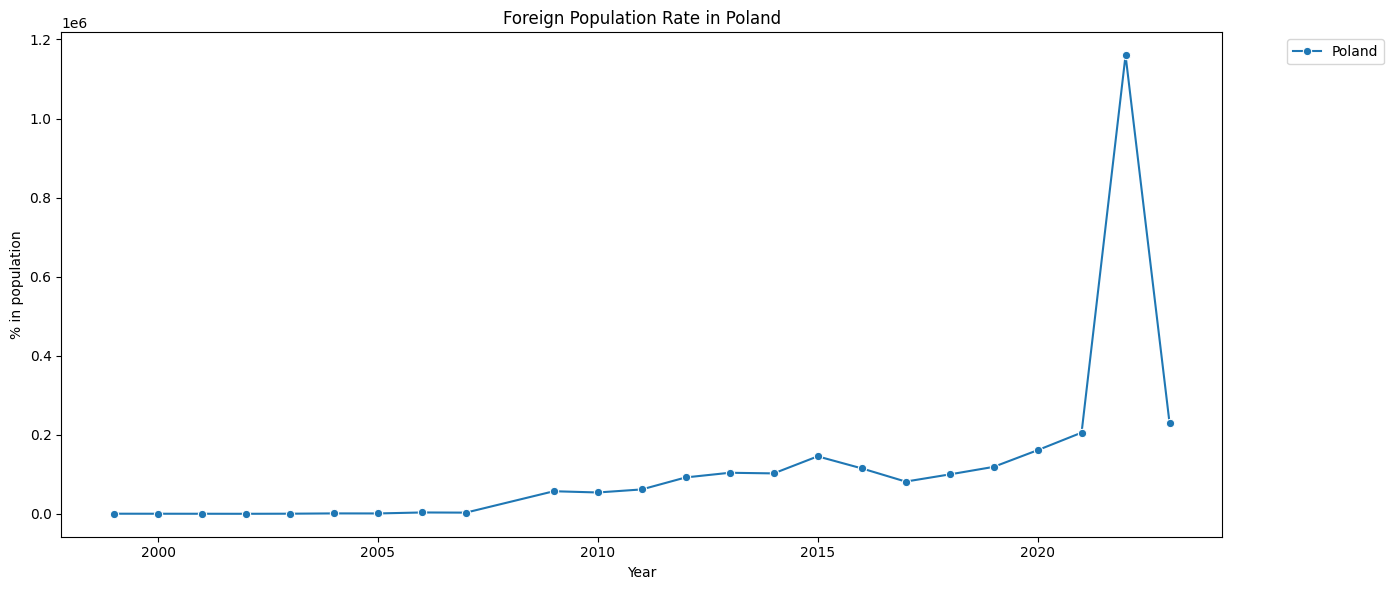

In [147]:
selected = ["Poland", "Bulgaria", "Romania", "Hungary", "France", "Italy", "Germany", "Sweden", "Spain", "Greece", "Austria", "Belgium"]
# liberal countries
liberal = ["France", "Italy", "Germany", "Sweden", "Spain", "Austria"]

plt.figure(figsize=(14, 6))
sns.lineplot(data=combined[combined['geo'].isin(liberal)], x="year", y="foreigners", hue="geo", marker="o")
plt.title("Foreign Population Rate")
plt.ylabel("% in population")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# conservative countries
conservs = ["Bulgaria", "Romania", "Hungary", "Greece"] # Polska zaburza 2022 
plt.figure(figsize=(14, 6))
sns.lineplot(data=combined[combined['geo'].isin(conservs)], x="year", y="foreigners", hue="geo", marker="o")
plt.title("Foreign Population Rate")
plt.ylabel("% in population")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Poland
plt.figure(figsize=(14, 6))
sns.lineplot(data=combined[combined['geo'] == 'Poland'], x="year", y="foreigners", hue="geo", marker="o")
plt.title("Foreign Population Rate in Poland")
plt.ylabel("% in population")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [155]:
df_selected = combined[combined["geo"].isin(selected) & (combined['year'] >= 2012)].copy()


df_selected["EU_share"] = df_selected["foreigners_pop_share"] - df_selected["non_EU_pop_share"]


df_melted = df_selected.melt(
    id_vars=["geo", "year"],
    value_vars=["EU_share", "non_EU_pop_share"],
    var_name="Origin",
    value_name="Share"
)


origin_map = {
    "EU_share": "From EU countries",
    "non_EU_pop_share": "From non-EU countries",
}
df_melted["Origin"] = df_melted["Origin"].map(origin_map)

# Wykres Plotly
fig = px.area(df_melted, 
              x="year", 
              y="Share", 
              color="Origin", 
              facet_col="geo", 
              facet_col_wrap=4,
              title="Structure of Foreign Immgirants accpeted in selected countries (2012 - 2023)",
              labels={"Share": "Share of population", "year": "Year"},
              category_orders={"Origin": ["From EU countries", "From non-EU countries (excl. Ukraine)", "From Ukraine"]})

fig.update_layout(legend_title_text="Origin", height=800)
fig.show()

In [153]:
df_heat = combined[combined["geo"].isin(selected) & (combined["year"] > 2012)].copy()

df_heat["foreigners_pop_share"] = df_heat["foreigners_pop_share"].round(2)

heat_data = df_heat.pivot(index="geo", columns="year", values="foreigners_pop_share")

heat_data = heat_data.loc[heat_data.mean(axis=1).sort_values(ascending=False).index]

fig = px.imshow(
    heat_data,
    labels=dict(x="Year", y="Country", color="Foreigners (% of pop)"),
    color_continuous_scale="YlGnBu", 
    aspect="auto",
    text_auto=True,
    title="Change in Foreigners accepted as % of Population (2012–2024)"
)

fig.update_layout(height=600)
fig.show()

In [152]:
df_heat = combined[combined["geo"].isin(selected) & (combined["year"] >= 2012)].copy()

df_heat["foreigners"] = df_heat["foreigners"].round(2)

heat_data = df_heat.pivot(index="geo", columns="year", values="foreigners")

heat_data = heat_data.loc[heat_data.mean(axis=1).sort_values(ascending=False).index]

fig = px.imshow(
    heat_data,
    labels=dict(x="Year", y="Country", color="Foreigners"),
    color_continuous_scale="YlGnBu", 
    aspect="auto",
    text_auto=True,
    title="Foreigners immigrants in selected countries (2012-2023)"
)

fig.update_layout(height=600)
fig.show()

Francja wydaje się nie być tak otwartym na migrantów krajem jakby się powszechnie wydawało.

# Population by citizenship combined data

Analiza zbioru danych zawierającego istotne informacje dotyczące immigrantów. 
Zbiór danych powstał na potrzeby analizy migrants vs inne współczynniki. Należy pamiętać o fakcie, że dane dotyczące populacji są zbierane ze stanem na 1 stycznia danego roku.

In [166]:
combined = pd.read_csv('../processed_data/population_by_citizenship_combined_data.csv')

In [167]:
combined.head()

geo  year        EU  from_Ukraine   national     non_EU  foreigners  \
0  Austria  2015  560680.0        8582.0  7438848.0  1715038.0   2275718.0   
1  Austria  2016  606439.0        9669.0  7432797.0  1909181.0   2515620.0   
2  Austria  2017  645156.0       10199.0  7430935.0  2016039.0   2661195.0   
3  Austria  2018  683174.0       10700.0  7426387.0  2077116.0   2760290.0   
4  Austria  2019  719239.0       11162.0  7419852.0  2128722.0   2847961.0   

  iso_a3  foreigners_pop_share  non_EU_pop_share  ukraine_pop_share  \
0    AUT             23.425833         17.654294           0.088342   
1    AUT             25.286636         19.190802           0.097191   
2    AUT             26.369012         19.976348           0.101059   
3    AUT             27.097060         20.390516           0.105039   
4    AUT             27.736783         20.731990           0.108709   

   ukraine_for_share  non_EU_for_share  
0           0.377112         75.362501  
1           0.384359         75.893060  
2           0.383249         75.756906  
3           0.387640         75.249919  
4           0.391930         74.745476

### Interaktywna mapa ukazująca dynamikę zmian

In [168]:
fig = px.choropleth(combined[combined['geo'] != 'Luxembourg'],   # Luksemburg ma jakieś chore wartości i psuje mi ładną mapę
                    locations="iso_a3", 
                    color="foreigners_pop_share",
                    hover_name="geo",
                    animation_frame="year",
                    scope= 'europe',
                    color_continuous_scale="Portland",
                    title="Foreigners rate in populations - EU countries (2015-2024)")
fig.show()

### Trendy czasowe

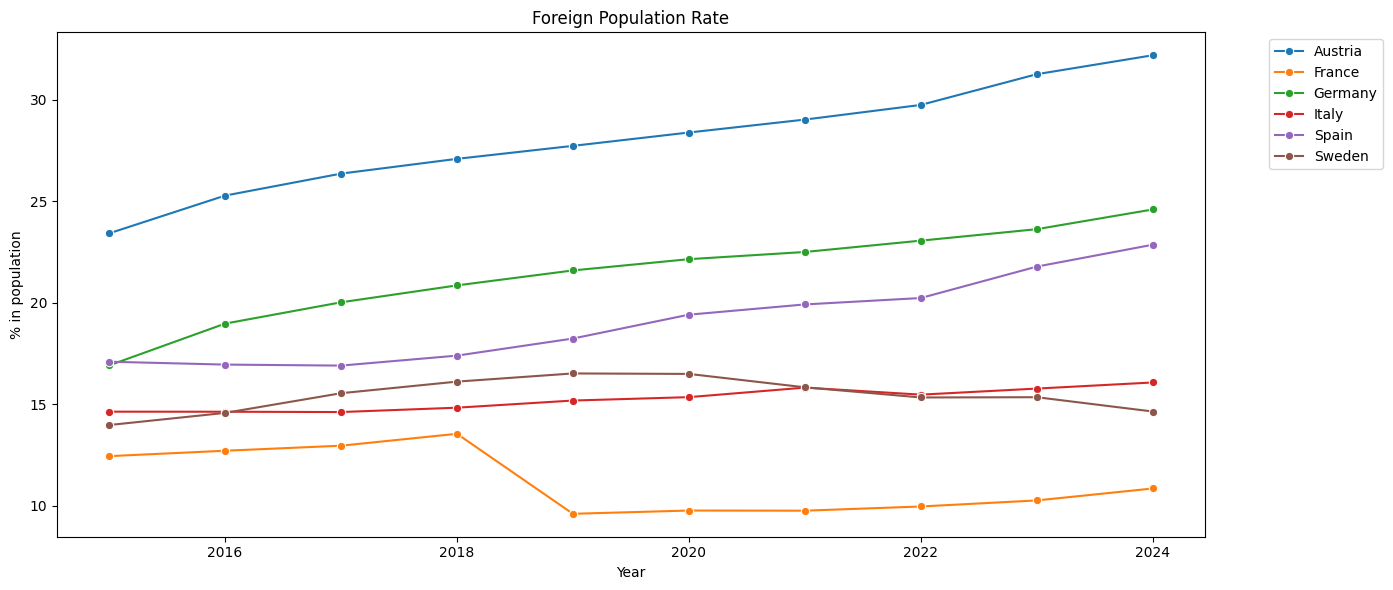

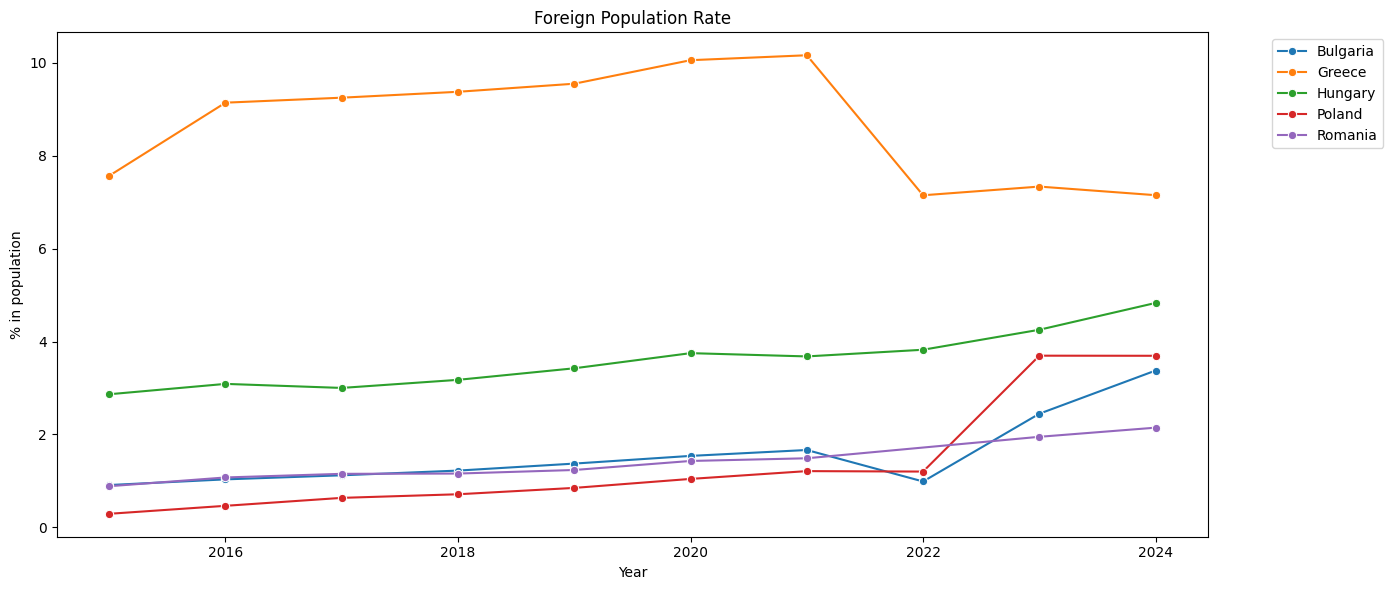

In [169]:
selected = ["Poland", "Bulgaria", "Romania", "Hungary", "France", "Italy", "Germany", "Sweden", "Spain", "Greece", "Austria"]
# liberal countries
liberal = ["France", "Italy", "Germany", "Sweden", "Spain", "Austria"]

plt.figure(figsize=(14, 6))
sns.lineplot(data=combined[combined['geo'].isin(liberal)], x="year", y="foreigners_pop_share", hue="geo", marker="o")
plt.title("Foreign Population Rate")
plt.ylabel("% in population")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# conservative countries
conservs = ["Poland", "Bulgaria", "Romania", "Hungary", "Greece"]
plt.figure(figsize=(14, 6))
sns.lineplot(data=combined[combined['geo'].isin(conservs)], x="year", y="foreigners_pop_share", hue="geo", marker="o")
plt.title("Foreign Population Rate")
plt.ylabel("% in population")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [170]:
df_selected = combined[combined["geo"].isin(selected)].copy()


df_selected["EU_share"] = df_selected["foreigners_pop_share"] - df_selected["non_EU_pop_share"]


df_melted = df_selected.melt(
    id_vars=["geo", "year"],
    value_vars=["EU_share", "non_EU_pop_share"],
    var_name="Origin",
    value_name="Share"
)


origin_map = {
    "EU_share": "From EU countries",
    "non_EU_pop_share": "From non-EU countries",
}
df_melted["Origin"] = df_melted["Origin"].map(origin_map)

fig = px.area(df_melted, 
              x="year", 
              y="Share", 
              color="Origin", 
              facet_col="geo", 
              facet_col_wrap=4,
              title="Structure of Foreign Population by Origin (2015–2024)",
              labels={"Share": "Share of population", "year": "Year"},
              category_orders={"Origin": ["From EU countries", "From non-EU countries"]})

fig.update_layout(legend_title_text="Origin", height=800)
fig.show()

In [171]:
df_2024 = combined[combined["year"] == 2024].copy()

top5 = df_2024.nlargest(10, "foreigners_pop_share")

fig1 = px.bar(top5,
              x="geo",
              y="foreigners_pop_share",
              title="Top 10 Countries by Share of Foreigners in Population (2024)",
              labels={"foreigners_pop_share": "Share of Foreigners (%)", "geo": "Country"},
              text=top5["foreigners_pop_share"].round(2))

fig1.update_traces(textposition='outside')
fig1.update_layout(yaxis_title="Foreigners as % of population")
fig1.update_layout(height=600)

In [172]:
df_2024 = combined[combined["year"] == 2024].copy()

bottom10 = df_2024.nsmallest(10, "foreigners_pop_share")

fig2 = px.bar(bottom10,
              x="geo",
              y="foreigners_pop_share",
              title="Bottom 5 Countries by Share of Foreigners in Population (2024)",
              labels={"foreigners_pop_share": "Share of Foreigners (%)", "geo": "Country"},
              text=bottom10["foreigners_pop_share"].round(2))

fig2.update_traces(textposition='outside')
fig2.update_layout(height=600)

In [173]:
df_heat = combined[combined["geo"].isin(selected)].copy()

df_heat["foreigners_pop_share"] = df_heat["foreigners_pop_share"].round(2)

heat_data = df_heat.pivot(index="geo", columns="year", values="foreigners_pop_share")

heat_data = heat_data.loc[heat_data.mean(axis=1).sort_values(ascending=False).index]

fig = px.imshow(
    heat_data,
    labels=dict(x="Year", y="Country", color="Foreigners (% of pop)"),
    color_continuous_scale="YlGnBu", 
    aspect="auto",
    text_auto=True,
    title="Change in Foreigners as % of Population (2012–2024)"
)

fig.update_layout(height=600)
fig.show()

Bardzo ładnie widać liberalizm i konserwatyzm.

# Refugees 

### Anliza dynamiki zmian 

In [28]:
ref = pd.read_csv('../processed_data/refugees.csv')

In [20]:
ref.head()

year      geo  Refugees  Refugees_change  Refugees_arrived
0  2008  Austria     37546              NaN               NaN
1  2009  Austria     38895           1349.0            1349.0
2  2010  Austria     42613           3718.0            3718.0
3  2011  Austria     47055           4442.0            4442.0
4  2012  Austria     51707           4652.0            4652.0

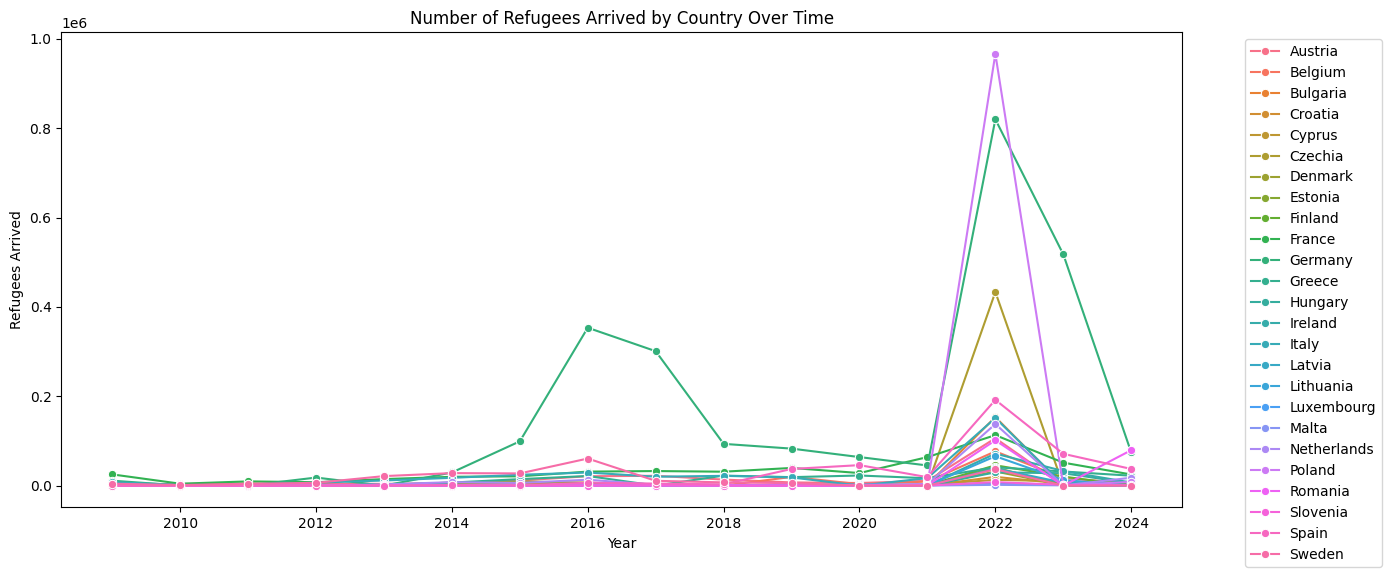

In [21]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=ref, x="year", y="Refugees_arrived", hue="geo", marker="o")
plt.title("Number of Refugees Arrived by Country Over Time")
plt.ylabel("Refugees Arrived")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

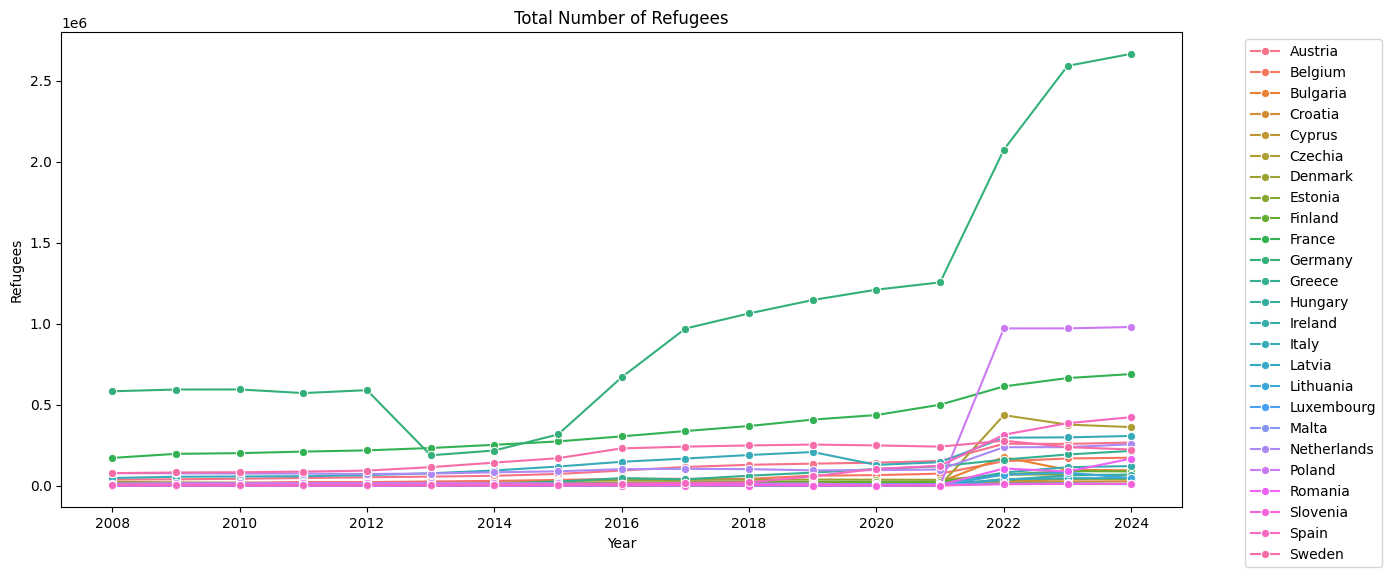

In [36]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=ref, x="year", y="Refugees", hue="geo", marker="o")
plt.title("Total Number of Refugees")
plt.ylabel("Refugees")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Największe zmiany w 2022 - zmiany powiązane z wybuchem wojny na Ukrainie

In [22]:
top_2022 = ref[ref["year"] == 2022].sort_values(by="Refugees_arrived", ascending=False)
print("Top countries by refugee arrivals in 2022:")
print(top_2022[["geo", "Refugees_arrived"]].head(10))

Top countries by refugee arrivals in 2022:
             geo  Refugees_arrived
354       Poland          966254.0
184      Germany          819751.0
99       Czechia          433303.0
405        Spain          191951.0
48      Bulgaria          153467.0
252        Italy          151319.0
337  Netherlands          137783.0
167       France          113020.0
14       Austria          106099.0
371      Romania          101421.0


In [23]:
summary = ref[ref["year"] >= 2022].groupby("geo")["Refugees_arrived"].sum().sort_values(ascending=False)
print("\n📊 Total refugee arrivals from 2022 onward:")
print(summary.head(10))


📊 Total refugee arrivals from 2022 onward:
geo
Germany        1411497.0
Poland          975159.0
Czechia         433303.0
Spain           300465.0
France          189359.0
Romania         180783.0
Italy           162046.0
Netherlands     155870.0
Bulgaria        153467.0
Austria         114493.0
Name: Refugees_arrived, dtype: float64


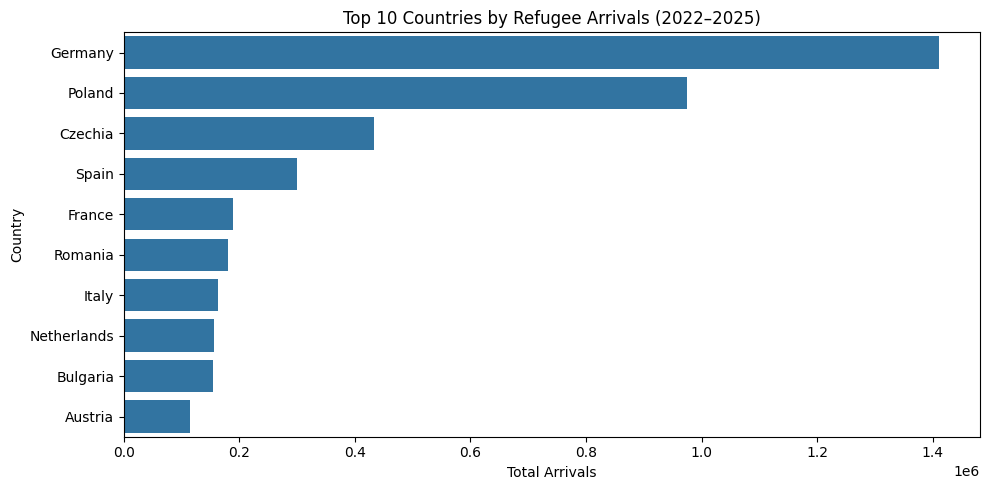

In [39]:
top_countries = summary.head(10).index

plt.figure(figsize=(10, 5))
sns.barplot(x=summary.loc[top_countries].values, y=top_countries)
plt.title('Top 10 Countries by Refugee Arrivals (2022–2025)')
plt.xlabel('Total Arrivals')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


In [24]:
selected_countries = ["Poland", "Bulgaria", "Romania", "Hungary", "France", "Italy", "Germany", "Sweden", "Spain", "Greece", "Slovenia"]

In [25]:
filtered = ref[ref['geo'].isin(selected_countries)]

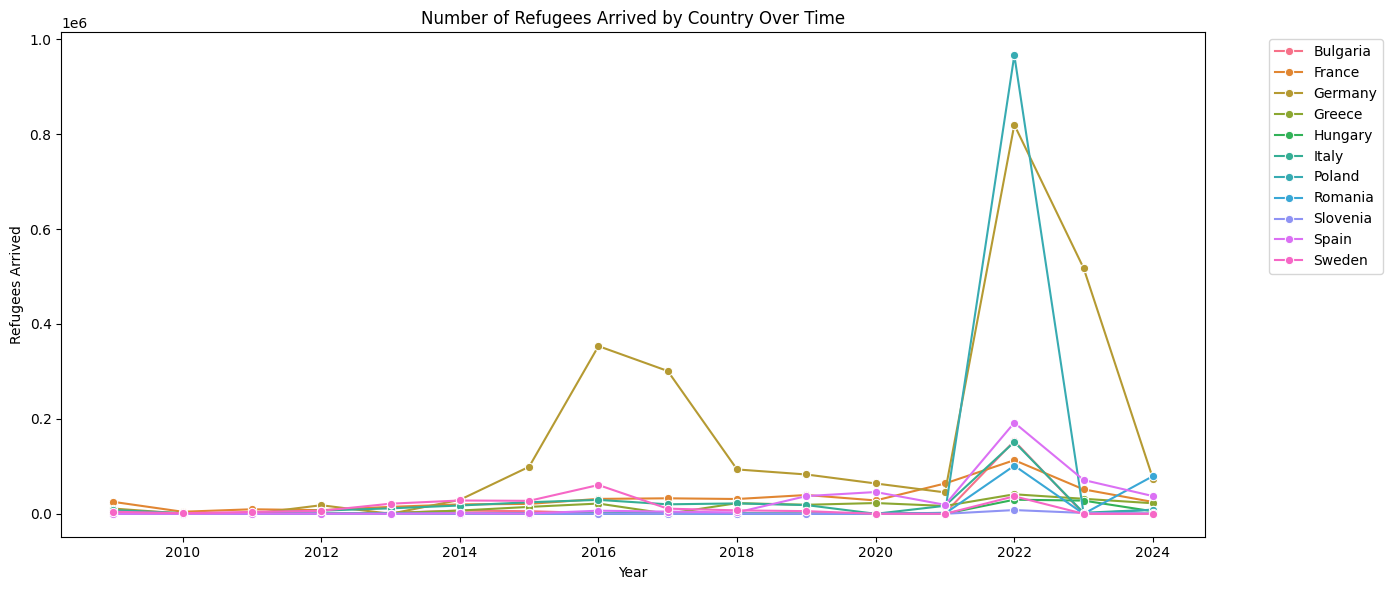

In [26]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=filtered, x="year", y="Refugees_arrived", hue="geo", marker="o")
plt.title("Number of Refugees Arrived by Country Over Time")
plt.ylabel("Refugees Arrived")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

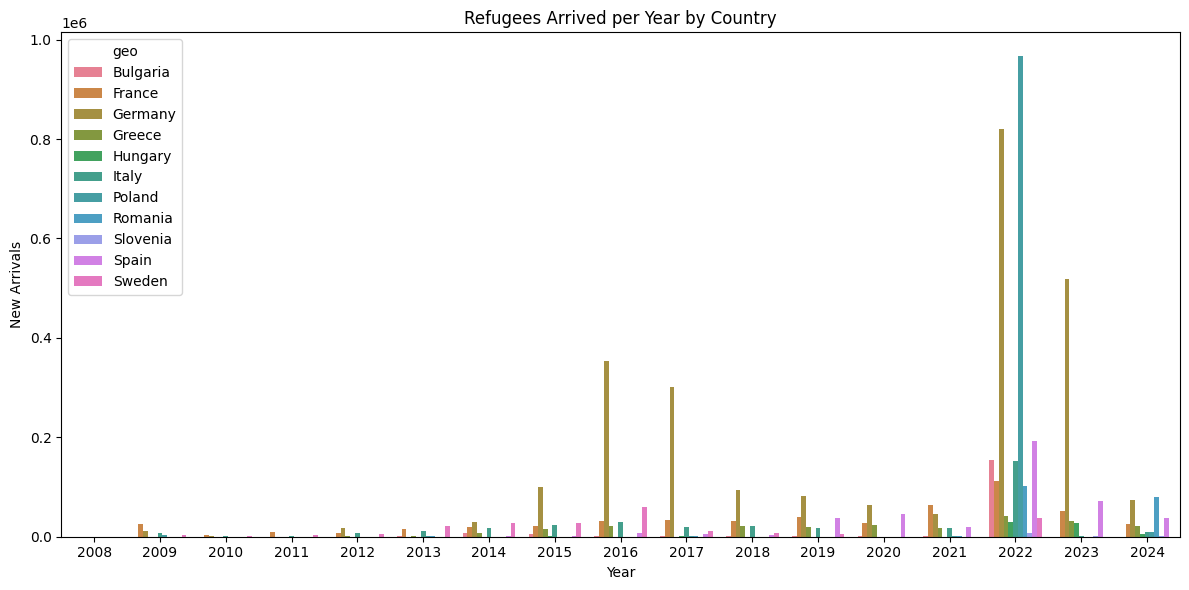

In [37]:
plt.figure(figsize=(12, 6))
sns.barplot(data=filtered, x='year', y='Refugees_arrived', hue='geo')
plt.title('Refugees Arrived per Year by Country')
plt.ylabel('New Arrivals')
plt.xlabel('Year')
plt.tight_layout()
plt.show()


### Studium przypadku - Polska, Niemcy, Szwecja

In [40]:
poland_data = ref[ref['geo'] == 'Poland']

C:\Users\natal\AppData\Local\Temp\ipykernel_18744\1488240680.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


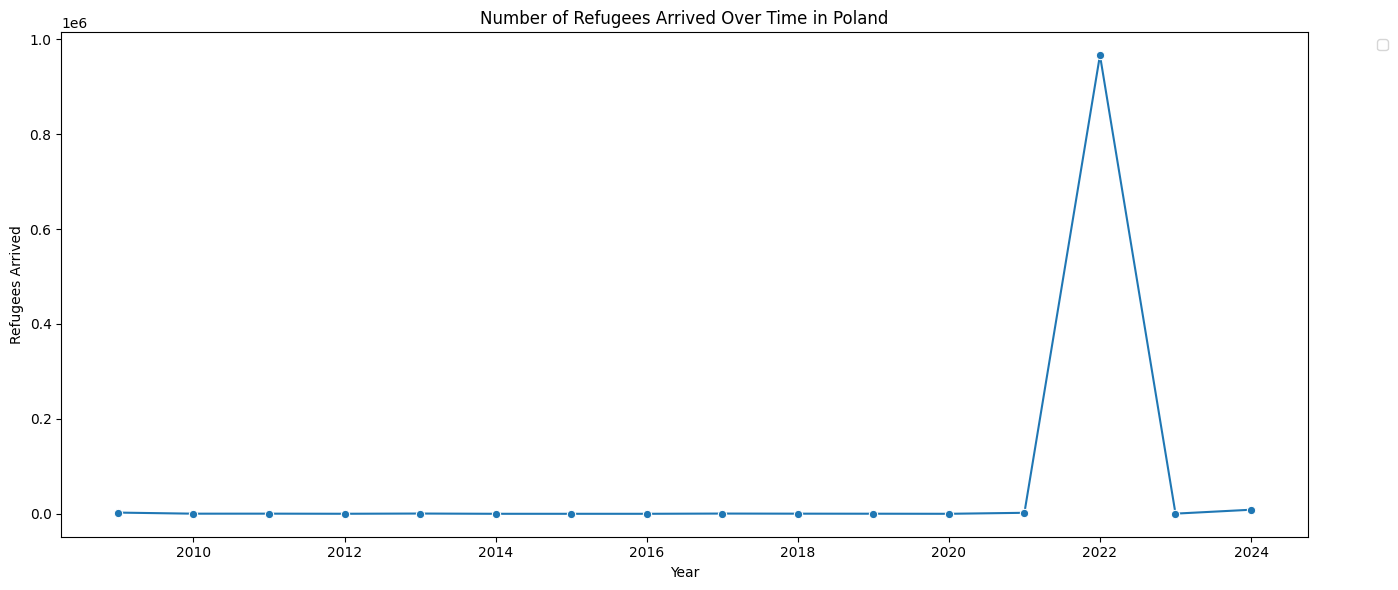

In [45]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=poland_data, x="year", y="Refugees_arrived", marker="o")
plt.title("Number of Refugees Arrived Over Time in Poland")
plt.ylabel("Refugees Arrived")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [46]:
germany_data = ref[ref['geo'] == 'Germany']

C:\Users\natal\AppData\Local\Temp\ipykernel_18744\3864606864.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


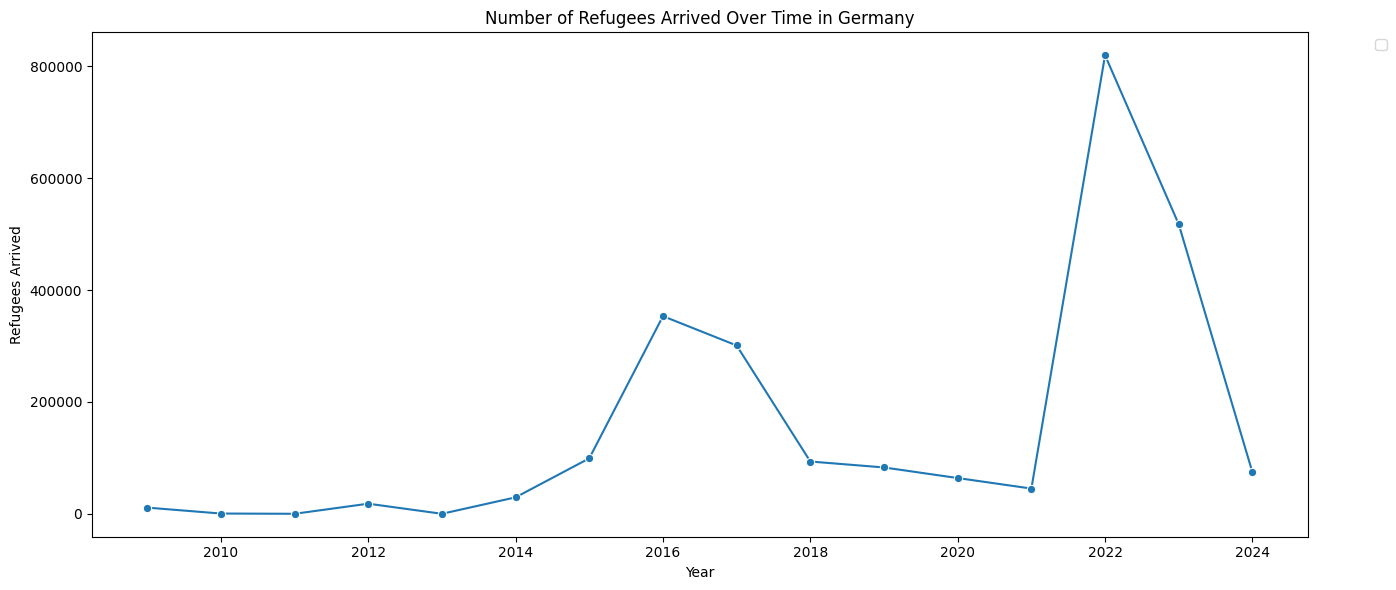

In [47]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=germany_data, x="year", y="Refugees_arrived", marker="o")
plt.title("Number of Refugees Arrived Over Time in Germany")
plt.ylabel("Refugees Arrived")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\natal\AppData\Local\Temp\ipykernel_18744\943862648.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


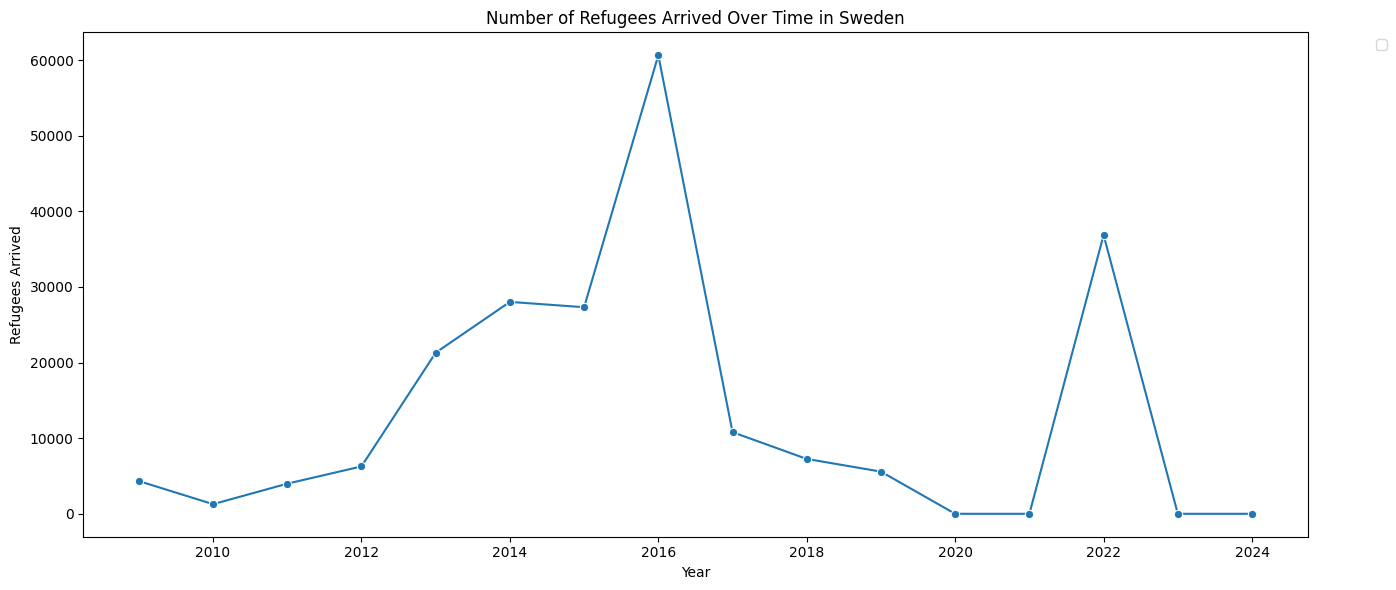

In [49]:
sweden_data = ref[ref['geo'] == 'Sweden']

plt.figure(figsize=(14, 6))
sns.lineplot(data=sweden_data, x="year", y="Refugees_arrived", marker="o")
plt.title("Number of Refugees Arrived Over Time in Sweden")
plt.ylabel("Refugees Arrived")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Studium przypadku - uchodźcy z Ukrainy

#### Total

In [17]:
ukr_total_ref = pd.read_csv('../processed_data/ukraine_refugees_total.csv')

In [5]:
ukr_total_ref.head()

year Country of Origin  Refugees
0  2008           Ukraine     28416
1  2009           Ukraine     24512
2  2010           Ukraine     25102
3  2011           Ukraine     25372
4  2012           Ukraine     25248

In [14]:
fig = px.line(
    ukr_total_ref,
    x='year',
    y='Refugees',
    title='Total Number of Ukrainian Refugees Over Time',
    markers=True,
    labels={
        'year': 'Year',
        'Refugees': 'Number of Refugees'
    }
)
fig.show()

#### In EU countries

In [32]:
eu_ukr = pd.read_csv('../processed_data/ukraine_refugees_eu.csv')

In [33]:
eu_ukr['geo'] = eu_ukr['geo'].replace({
    'Netherlands (Kingdom of the)': 'Netherlands'
})

In [34]:
eu_ukr.head()

year      geo Country of Origin iso_a3  Refugees
0  2008  Austria           Ukraine    AUT       221
1  2009  Austria           Ukraine    AUT       259
2  2010  Austria           Ukraine    AUT       282
3  2011  Austria           Ukraine    AUT       308
4  2012  Austria           Ukraine    AUT       309

In [39]:
pivot = eu_ukr.pivot_table(
    index='year',
    columns='geo',
    values='Refugees',
    aggfunc='sum',
    fill_value=0
)

# heatmap with Plotly 
fig = px.imshow(
    pivot,
    labels=dict(x="Country", y="Year", color="Number of Refugees"),
    color_continuous_scale="YlGnBu",
    aspect="auto",
    text_auto=True,
    title="Ukrainian Refugees in EU Countries (2008 - 2024)",
    width=1000
)
fig.update_yaxes(showticklabels=True, ticks="outside", tickvals=pivot.index)
fig.show()

Do roku 2021 niewiele się dzieje

In [60]:
recent_years = pivot.loc[2022:2024]
sorted_countries = recent_years.mean().sort_values(ascending=True).index

fig = px.imshow(
    recent_years[sorted_countries],
    labels=dict(x="Country", y="Year", color="Number of Refugees"),
    color_continuous_scale="YlGnBu",
    aspect="auto",
    text_auto=True,
    title="Ukrainian Refugees in EU Countries (2022 - 2024)",
    width=1000
)
fig.update_yaxes(showticklabels=True, ticks="outside", tickvals=pivot.index)
fig.show()

In [70]:
fig = px.bar(
    eu_ukr[eu_ukr['year'] == 2024].sort_values(by="Refugees", ascending=True),
    x='geo',
    y='Refugees',     
    title='Ukrainian Refugees in EU Countries (2024)',
    labels={'geo': 'Country', 'Refugees': 'Number of Refugees'},
    text='Refugees',
    color='Refugees',
    color_continuous_scale='YlGnBu'
)

fig.update_traces(texttemplate='%{text:,}', textposition='outside')
fig.update_layout(xaxis_tickangle=-45, width=1000)
fig.show()


In [74]:
# line plot - trends in selected countries
countries_of_interest = ['Germany', 'Poland', 'Czechia', 'Spain', 'Italy', 'Romania']
filtered_interest = eu_ukr[eu_ukr['geo'].isin(countries_of_interest)
                           & (eu_ukr['year'] >= 2021)]

fig = px.line(
    filtered_interest,
    x='year', 
    y='Refugees',
    color='geo',
    title='Trends of Ukrainian Refugees in Selected EU Countries (2008 - 2024)',
    markers=True,
    labels={'year': 'Year', 'Refugees': 'Number of Refugees', 'geo': 'Country'},
    category_orders={'geo': countries_of_interest}
)
fig.show()

In [ ]:
# sum of Ukrainians in EU countries
filtered_2024 = eu_ukr[(eu_ukr['year'] == 2024)]
total_ukr_eu = filtered_2024['Refugees'].sum()
print(total_ukr_eu/1000000, "milions of Ukrainian refugees in EU in 2024")

3.936369 milions of Ukrainian refugees in EU in 2024
